# Unsupervised outlier detection for Time series data using LSTM + AE
Feature : TMP ,HMD, TVOC, CO, CO2, CH2O, PM10 (7 features)   
Time : 2022-05-01 ~ 2022-05-19

## 0. Setting

In [1]:
pwd

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Outlier Detection Paper'

/content/drive/MyDrive/Outlier Detection Paper


In [4]:
!ls


 영석		 JunHyeok_0627_Main.ipynb     JunHyeok_0701.ipynb
'논문 작업'	 JunHyeok_0628_Backup.ipynb   lstm-ae-checkpoint
'준혁 옛날 거'	 JunHyeok_0628_연구용.ipynb   lstm_model_save
 data		 JunHyeok_0629.ipynb	      Reference
 Figure		 JunHyeok_0630.ipynb


### Library Call

In [5]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 10.6 MB/s 


In [6]:
# 상용 라이브러리
from glob import glob
import os
import pandas as pd
import numpy as np
from datetime import datetime
import time

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# Sckit-Learn 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

# Statistic Tools 라이브러리
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.cluster.hierarchy import dendrogram, linkage

# Tensorflow 라이브러리
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from keras import backend
from functools import partial
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Activation, Flatten, Dense
from keras import layers, models
from keras.utils import np_utils
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### User Function Definition

In [7]:
# BoxplotEDA Function Definition
def boxplotEDA(data,cols,nrow,ncol,title):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  plt.suptitle(title,y=0.92,size=30)
  i=0
  for col in cols:
    sns.boxplot(y = df[col], ax=ax[i//ncol,i%ncol], palette='Set3', linewidth=1.5)
    i+=1  

# Sublineplot
def subplots(data,cols,nrow,ncol,title):
  df = data[cols]
  fig, ax = plt.subplots(nrow, ncol, figsize=(6*ncol,5*nrow))
  plt.suptitle(title, y=0.92, size=30)
  i=0
  for col in cols:
    ax[i//ncol,i%ncol].plot(df[col])
    ax[i//ncol,i%ncol].set_ylabel(col)
    i+=1  
  
# lineplot
def lineplot(data,cols,title):
  df = data[cols]
  plt.figure(figsize=(20,10))
  plt.title(title, y=1.05, size=25)
  for col in cols:
    plt.plot(df[col], label=col)
  plt.legend(loc='upper right')  

# corr_matrix
def corr_matrix(data, cols, title):
  df = data[cols]
  colormap = plt.cm.PuBu 
  plt.figure(figsize=(12, 12)) 
  plt.title(title, y=1.05, size=20)
  sns.heatmap(df.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
              square = True, cmap = colormap, linecolor = "white", annot = True, fmt='.2f',
              annot_kws = {"size" : 12})
  plt.show()

# IQR Based Outlier Processing Function Definition
def outliers_iqr(data):
  q1,q3 = np.percentile(data,[25,75])
  iqr=q3-q1
  lower_bound=  q1 - (iqr *1.5)
  upper_bound = q3 + (iqr *1.5)
  data[data>upper_bound] = np.nan #np.mean(data)
  data[data<lower_bound] = np.nan #np.mean(data)
  data.interpolate(method="ffill", inplace=True)
  data.interpolate(method="bfill", inplace=True)
  return data

# Reconstruction Error Computation Function
def RE_SCORE(X_input, X_pred):
    score = pd.DataFrame(index = X_pred.index)
    score['RE_SCORE'] = np.mean(np.square(X_input-X_pred),axis=1)
    return score

## 1. Data Load

### Device 11

In [8]:
# glob Function File Loading
filst = sorted(glob('data/*.csv'))
filst

['data/device11_5_1_5_25.csv',
 'data/device16_0629.csv',
 'data/device16_5_1_5_25.csv',
 'data/df11.csv']

In [9]:
# Sensor Data Load
device11 = pd.read_csv(filst[0])
device16 = pd.read_csv(filst[1])

In [10]:
print(device11.shape)
device11.head()

(17090, 17)


DeviceName                              EntityId                TsYMD  \
0  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:01:08   
1  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:03:08   
2  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:05:08   
3  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:07:09   
4  Device 10000011  d369b400-144d-11ec-80c8-b1d8e607054f  2022-05-01 00:09:09   

   CH2O  PM2.5  PM10    TVOC    CO2  Temperature  Humidity  Radioactivity  \
0  25.0   10.0  18.0  1377.0  545.0        23.27     21.45            0.0   
1  25.0   10.0  19.0  1377.0  544.0        20.51     21.46            0.0   
2  25.0   10.0  18.0  1383.0  546.0        21.87     21.46            0.0   
3  25.0   10.0  18.0  1374.0  547.0        21.87     21.48            0.0   
4  25.0   10.0  18.0  1380.0  548.0        21.86     21.48            0.0   

   Sound    CO  Stink   NO2  H2S  NH3  
0   38.0  0.99   0.03  0.01  0.0  0.0  
1   33.0  0.82   0.03  0.01  0.0  0.0  
2   33.0  0.50   0.03  0.01  0.0  0.0  
3   36.0  0.52   0.03  0.01  0.0  0.0  
4   35.0  0.37   0.03  0.01  0.0  0.0

In [11]:
# Device11 Information
device11.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17090 entries, 0 to 17089
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DeviceName     17090 non-null  object 
 1   EntityId       17090 non-null  object 
 2   TsYMD          17090 non-null  object 
 3   CH2O           17090 non-null  float64
 4   PM2.5          17090 non-null  float64
 5   PM10           17090 non-null  float64
 6   TVOC           17090 non-null  float64
 7   CO2            17090 non-null  float64
 8   Temperature    17090 non-null  float64
 9   Humidity       17090 non-null  float64
 10  Radioactivity  17090 non-null  float64
 11  Sound          17090 non-null  float64
 12  CO             17090 non-null  float64
 13  Stink          17090 non-null  float64
 14  NO2            17090 non-null  float64
 15  H2S            17090 non-null  float64
 16  NH3            17090 non-null  float64
dtypes: float64(14), object(3)
memory usage: 2.2+ MB


In [12]:
# Device11 Description
device11.describe()

CH2O         PM2.5          PM10          TVOC           CO2  \
count  17090.000000  17090.000000  17090.000000  17090.000000  17090.000000   
mean      28.538268      6.259450     10.744470   2225.640316    549.528672   
std       13.051426      6.034512     11.267901   1069.545831    113.073053   
min        0.000000      0.000000      0.000000      0.000000    400.000000   
25%       22.000000      3.000000      5.000000   1357.000000    450.000000   
50%       28.000000      4.000000      7.000000   2104.500000    547.000000   
75%       35.000000      8.000000     14.000000   2946.000000    624.000000   
max      333.000000     74.000000    137.000000   7034.000000   1476.000000   

        Temperature      Humidity  Radioactivity         Sound            CO  \
count  17090.000000  17090.000000        17090.0  17090.000000  17090.000000   
mean      24.076917     20.231280            0.0     40.425102      0.645453   
std        2.279940      3.350303            0.0      3.729020      0.126773   
min       17.350000      9.660000            0.0     27.000000      0.000000   
25%       22.430000     17.740000            0.0     38.000000      0.560000   
50%       23.860000     20.250000            0.0     41.000000      0.640000   
75%       25.520000     22.100000            0.0     43.000000      0.720000   
max       33.620000     32.040000            0.0     60.000000      1.540000   

              Stink           NO2      H2S      NH3  
count  17090.000000  17090.000000  17090.0  17090.0  
mean       0.027205      0.009879      0.0      0.0  
std        0.004499      0.001091      0.0      0.0  
min        0.000000      0.000000      0.0      0.0  
25%        0.020000      0.010000      0.0      0.0  
50%        0.030000      0.010000      0.0      0.0  
75%        0.030000      0.010000      0.0      0.0  
max        0.030000      0.010000      0.0      0.0

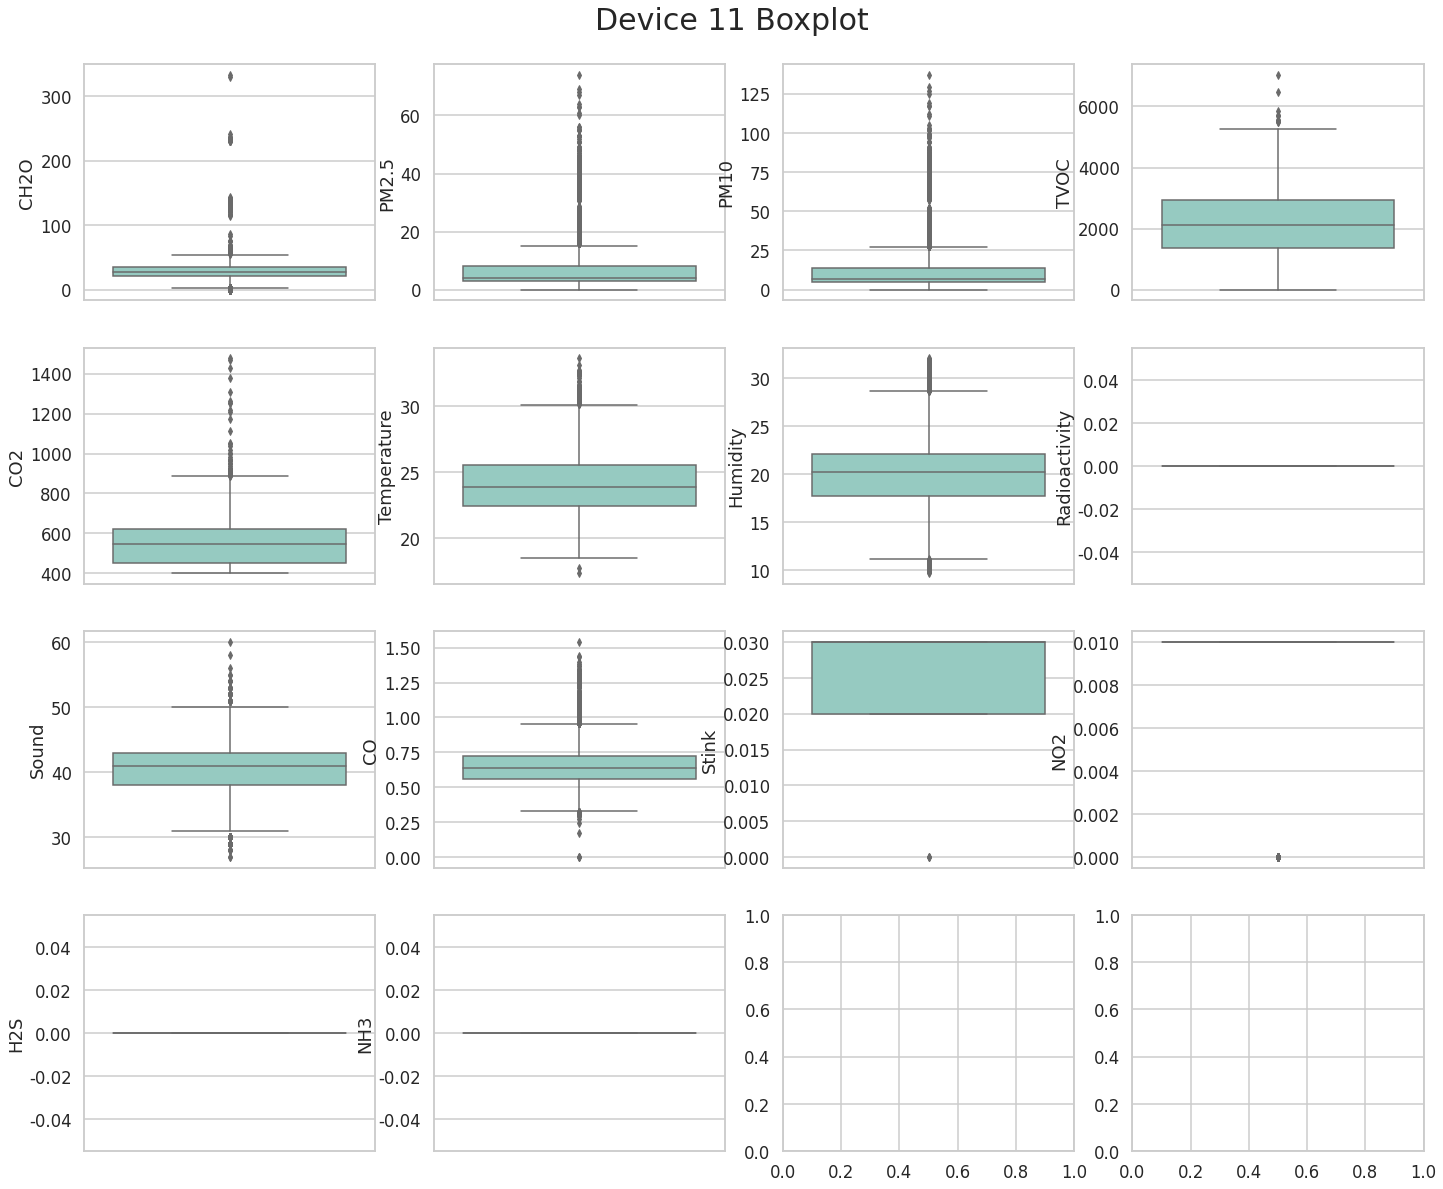

In [13]:
# Device11 Boxplot
boxplotEDA(device11,device11.columns[3:],4,4,'Device 11 Boxplot')

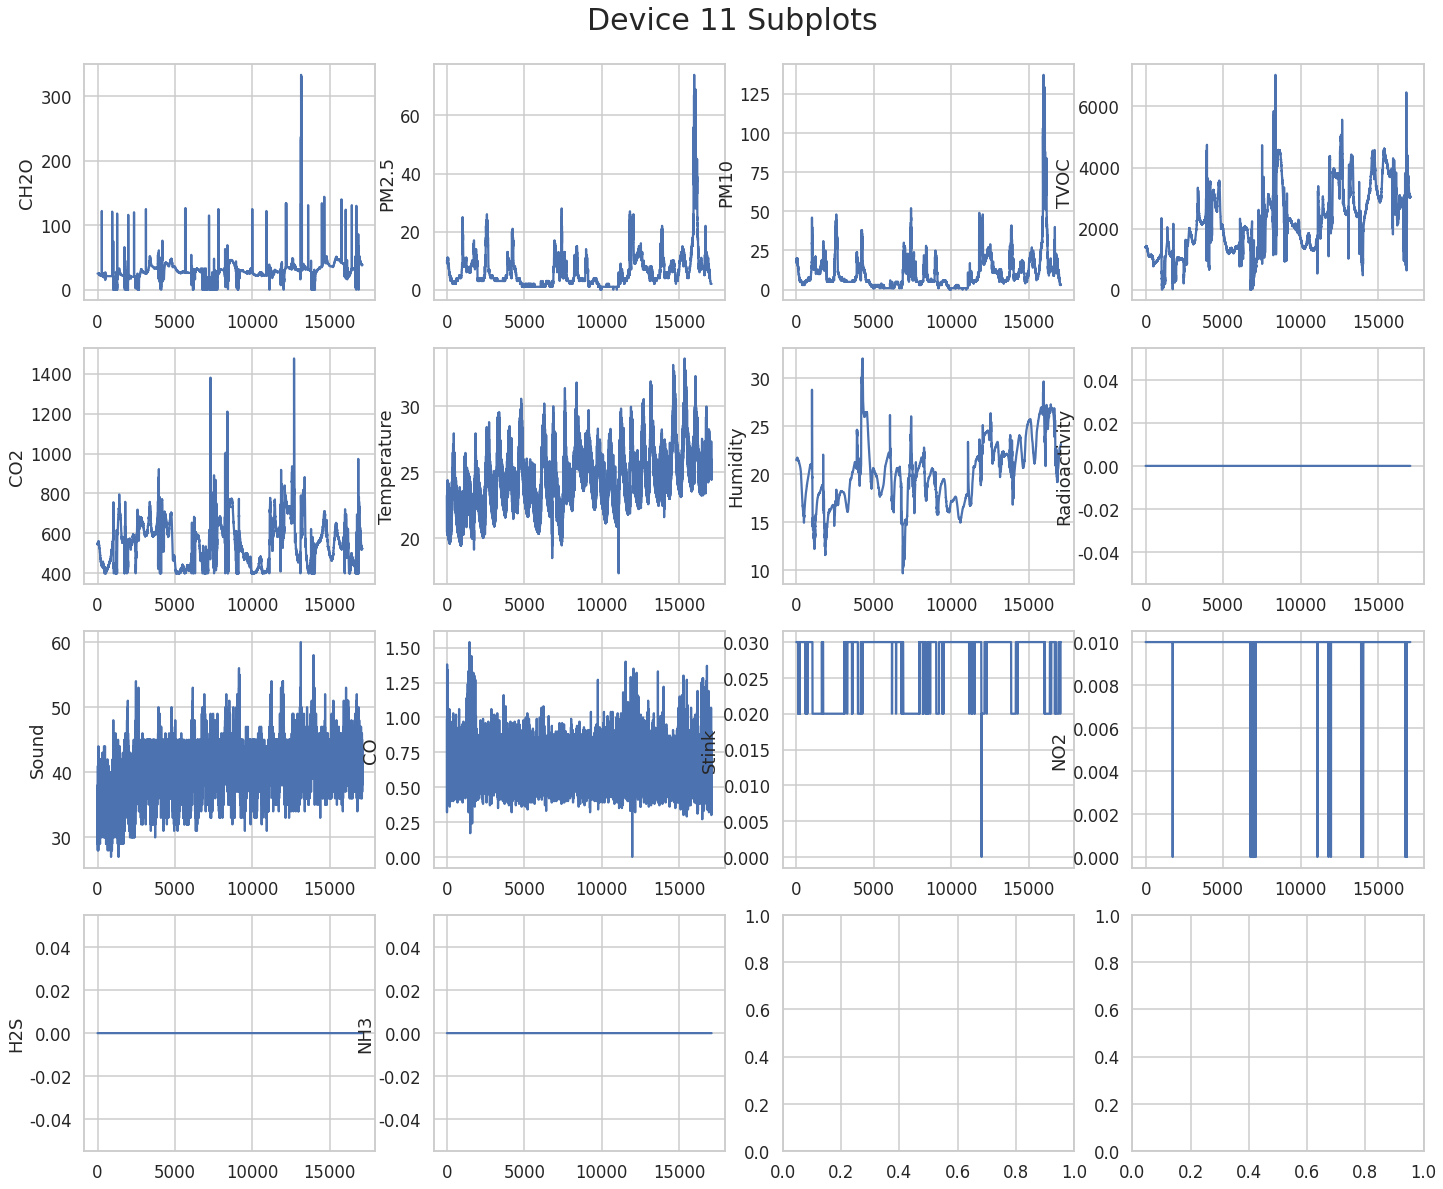

In [14]:
# Device11 Subplots
subplots(device11,device11.columns[3:],4,4,'Device 11 Subplots')

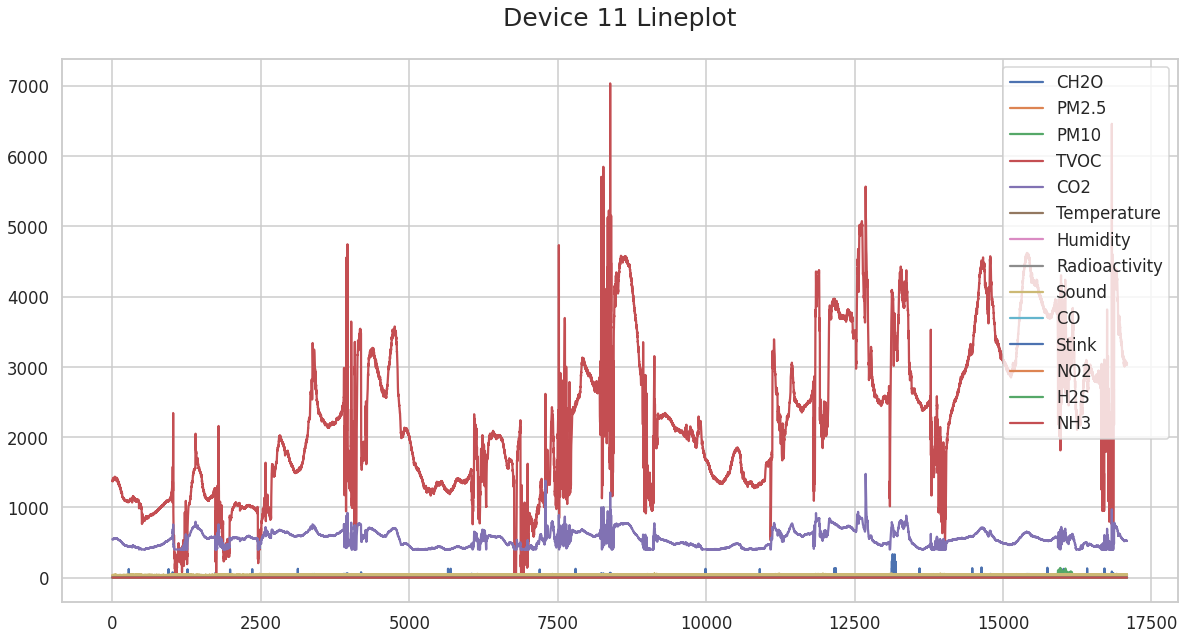

In [15]:
# Device11 Lineplot
lineplot(device11, device11.columns[3:],'Device 11 Lineplot')

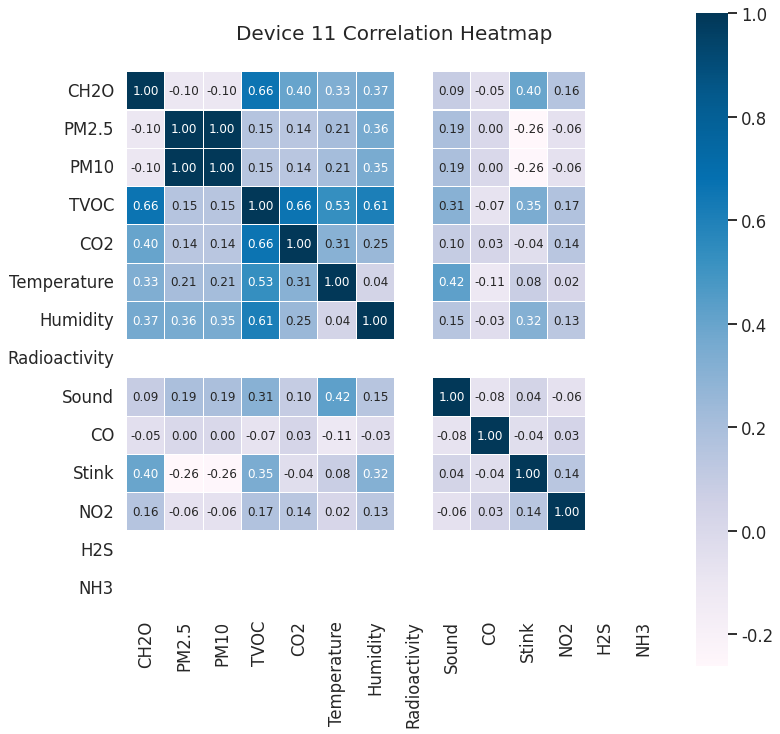

In [16]:
# Device11 Correlation Heatmap
corr_matrix(device11, device11.columns[3:], 'Device 11 Correlation Heatmap')

### Device 16

In [ ]:
print(device16.shape)
device16.head()

(16954, 17)


DeviceName                              EntityId                TsYMD  \
0  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:01:42   
1  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:03:42   
2  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:05:42   
3  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:07:43   
4  Device 10000016  08228f50-144e-11ec-80c8-b1d8e607054f  2022-05-01 00:09:43   

   CH2O  PM2.5  PM10    TVOC    CO2  Temperature  Humidity  Radioactivity  \
0  41.0   10.0  19.0  1441.0  511.0        21.05     21.64            0.0   
1  41.0   10.0  18.0  1428.0  514.0        23.79     21.64            0.0   
2  41.0    9.0  16.0  1471.0  516.0        22.41     21.64            0.0   
3  41.0   10.0  18.0  1463.0  518.0        21.02     21.63            0.0   
4  41.0   10.0  18.0  1464.0  517.0        22.40     21.66            0.0   

   Sound   CO  Stink  NO2  H2S  NH3  
0   37.0  0.0    0.0  0.0  0.0  0.0  
1   35.0  0.0    0.0  0.0  0.0  0.0  
2   33.0  0.0    0.0  0.0  0.0  0.0  
3   38.0  0.0    0.0  0.0  0.0  0.0  
4   34.0  0.0    0.0  0.0  0.0  0.0

In [ ]:
# Device16 Information
device16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16954 entries, 0 to 16953
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DeviceName     16954 non-null  object 
 1   EntityId       16954 non-null  object 
 2   TsYMD          16954 non-null  object 
 3   CH2O           16954 non-null  float64
 4   PM2.5          16954 non-null  float64
 5   PM10           16954 non-null  float64
 6   TVOC           16954 non-null  float64
 7   CO2            16954 non-null  float64
 8   Temperature    16954 non-null  float64
 9   Humidity       16954 non-null  float64
 10  Radioactivity  16954 non-null  float64
 11  Sound          16954 non-null  float64
 12  CO             16954 non-null  float64
 13  Stink          16954 non-null  float64
 14  NO2            16954 non-null  float64
 15  H2S            16954 non-null  float64
 16  NH3            16954 non-null  float64
dtypes: float64(14), object(3)
memory usage: 2.2+ MB


In [ ]:
# Device16 Description
device16.describe()

CH2O         PM2.5          PM10          TVOC           CO2  \
count  16954.000000  16954.000000  16954.000000  16954.000000  16954.000000   
mean      48.533915      6.273328     10.713342   2257.573847    543.657839   
std       17.727884      5.210495      9.692058   1145.194732    108.421800   
min       10.000000      1.000000      1.000000      0.000000    400.000000   
25%       37.000000      3.000000      5.000000   1299.250000    443.000000   
50%       46.000000      5.000000      8.000000   2120.000000    545.000000   
75%       60.000000      8.000000     13.000000   3060.000000    616.000000   
max      225.000000     69.000000    127.000000   8611.000000   1311.000000   

        Temperature      Humidity  Radioactivity         Sound            CO  \
count  16954.000000  16954.000000        16954.0  16954.000000  16954.000000   
mean      23.988897     20.907153            0.0     34.675239      0.240119   
std        2.025520      3.186919            0.0      4.719826      0.118233   
min       19.090000     10.950000            0.0     26.000000      0.000000   
25%       22.490000     18.510000            0.0     31.000000      0.210000   
50%       23.830000     20.830000            0.0     34.000000      0.260000   
75%       25.350000     22.790000            0.0     37.000000      0.310000   
max       31.460000     31.270000            0.0     59.000000      0.840000   

              Stink           NO2      H2S           NH3  
count  16954.000000  16954.000000  16954.0  16954.000000  
mean       0.398862      0.008459      0.0      0.278223  
std        0.175390      0.003611      0.0      0.448137  
min        0.000000      0.000000      0.0      0.000000  
25%        0.430000      0.010000      0.0      0.000000  
50%        0.450000      0.010000      0.0      0.000000  
75%        0.470000      0.010000      0.0      1.000000  
max        0.600000      0.010000      0.0      1.000000

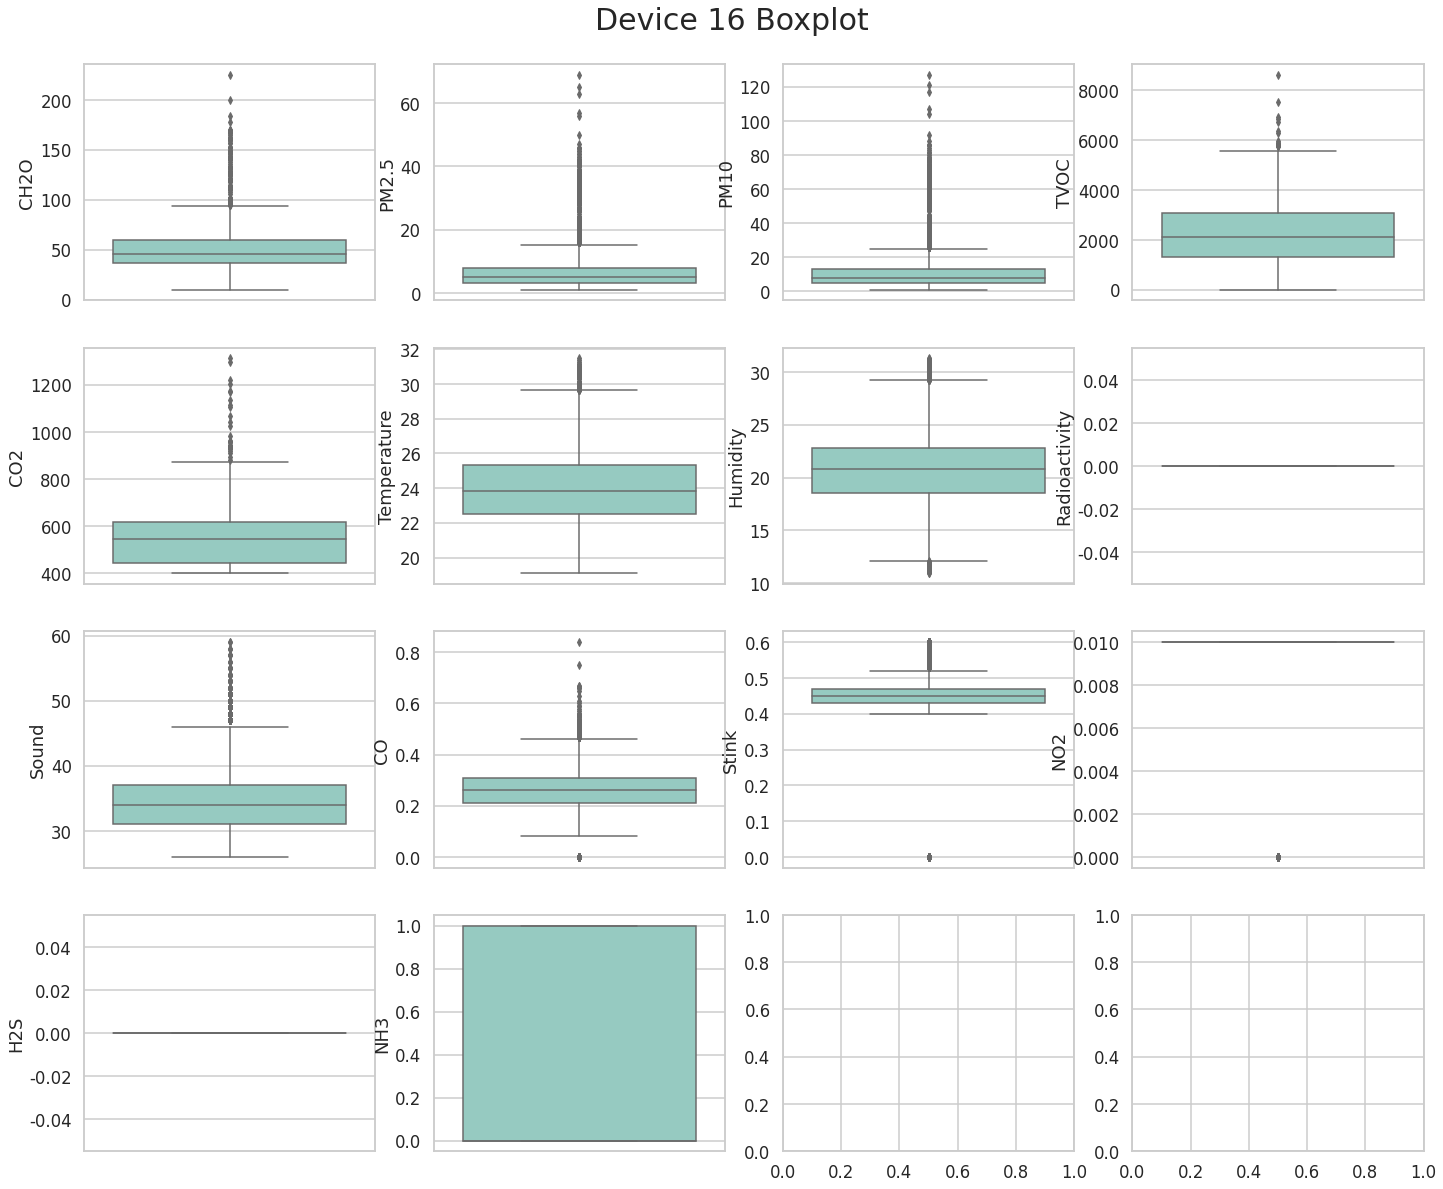

In [ ]:
# Device16 Boxplot
boxplotEDA(device16,device16.columns[3:],4,4,'Device 16 Boxplot')

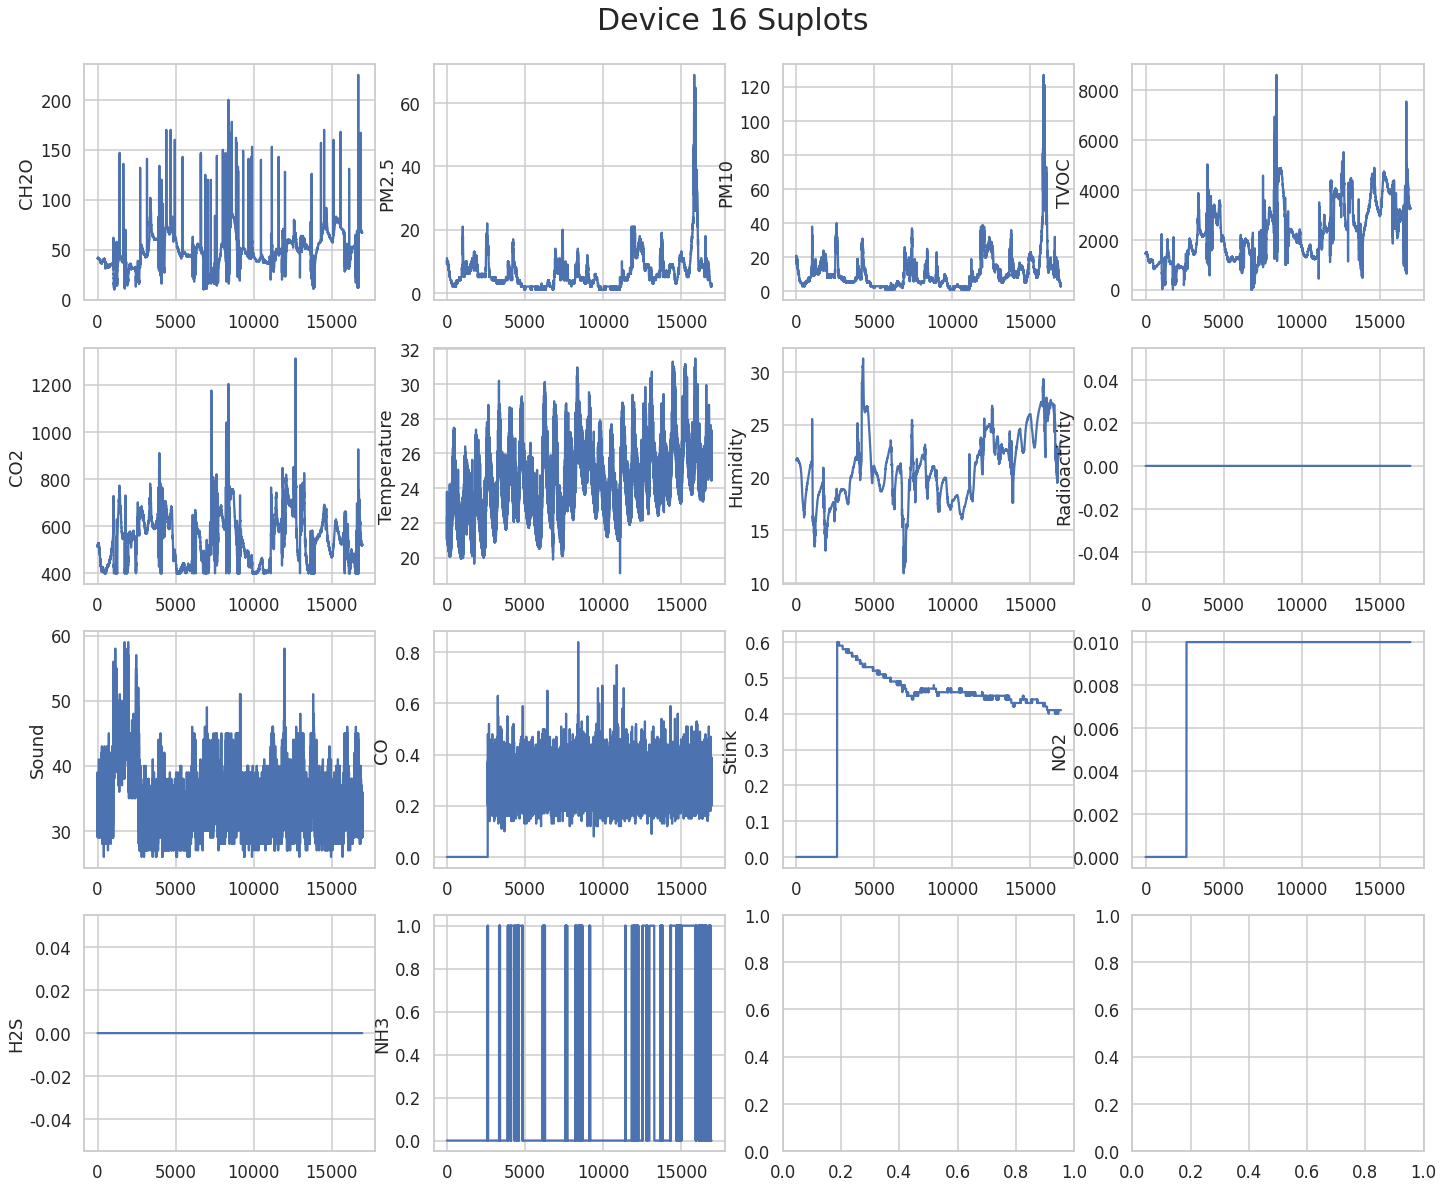

In [ ]:
# Device16 Subplots
subplots(device16,device16.columns[3:],4,4,'Device 16 Suplots')

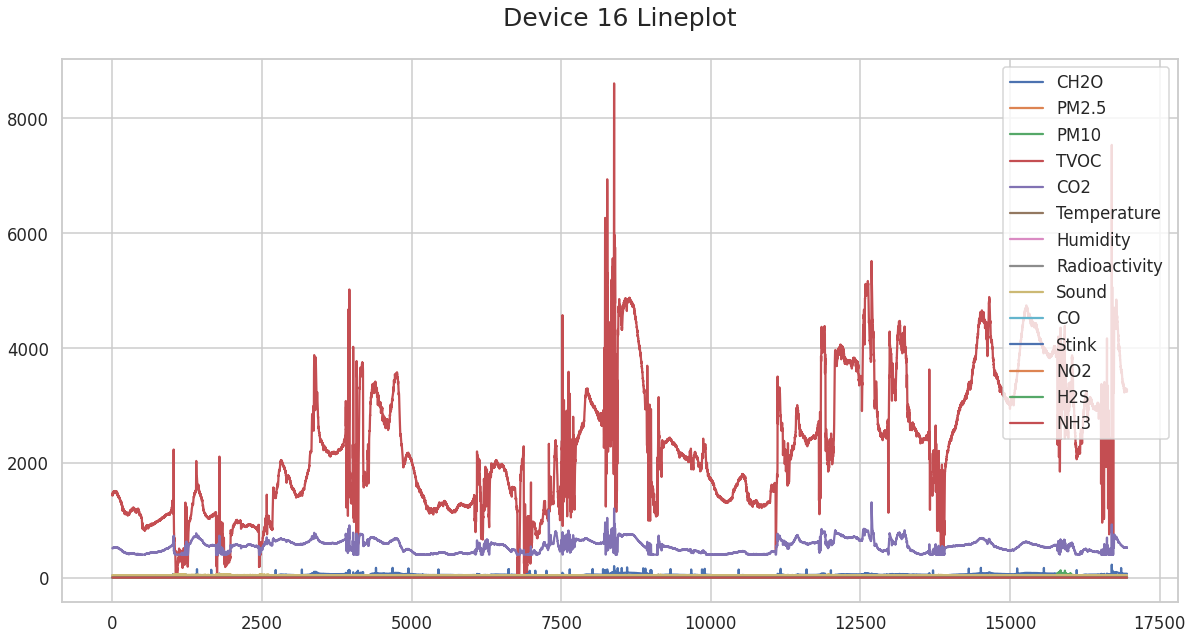

In [ ]:
# Device16 Lineplot
lineplot(device16, device16.columns[3:],'Device 16 Lineplot')

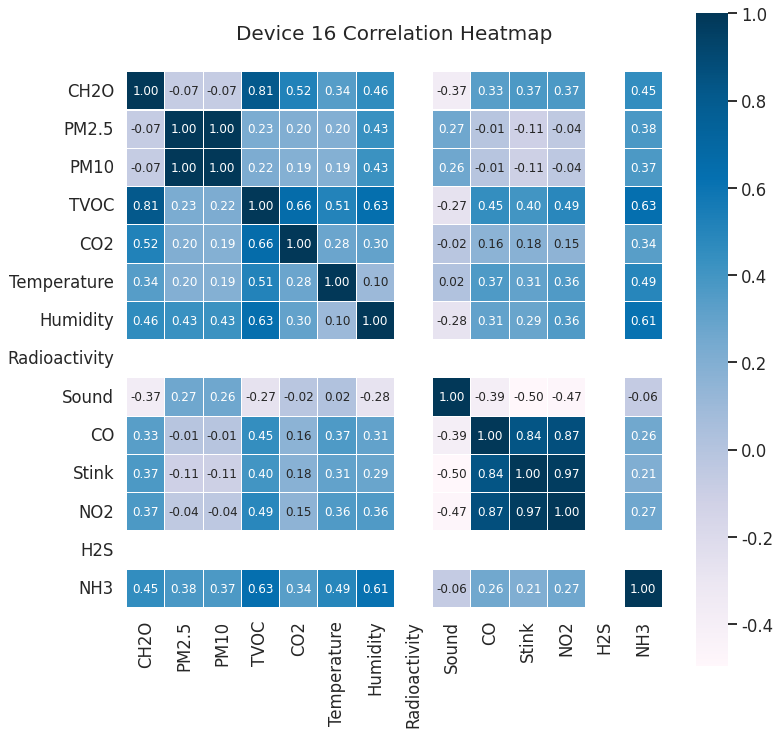

In [ ]:
# Device16 Correlation Heatmap
corr_matrix(device16, device16.columns[3:],'Device 16 Correlation Heatmap')

## 2. Data Prprocessing

### Data Feature Selection

In [ ]:
d11=device11.copy()
d16=device16.copy()

In [ ]:
d11.columns

Index(['DeviceName', 'EntityId', 'TsYMD', 'CH2O', 'PM2.5', 'PM10', 'TVOC',
       'CO2', 'Temperature', 'Humidity', 'Radioactivity', 'Sound', 'CO',
       'Stink', 'NO2', 'H2S', 'NH3'],
      dtype='object')

In [ ]:
# Feature Selection : ['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']
d11 = d11[['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']]
d16 = d16[['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']]
print('d11.shape :',d11.shape)
print('d16.shape :',d16.shape)

d11.shape : (17090, 8)
d16.shape : (16954, 8)


### Separate device because of long term over 2min


이거 해주는 이유 바로 아래 코드 보면 이해됨.  
2022-04-13 04:27 | 2022-04-13 10:18 사이 공백 발생 -> 공백 발생하는 곳마다 여러개의 dataframe으로 나눠 진행 필요

In [ ]:
d11['TsYMD'][4127:4131]
#d16['TsYMD'][8509:8513]

4127    2022-05-06 17:39:54
4128    2022-05-06 17:41:54
4129    2022-05-06 17:43:54
4130    2022-05-06 17:45:54
Name: TsYMD, dtype: object

여기부터 진행

In [ ]:
d11['TsYMD']=pd.to_datetime(d11['TsYMD'])
d11=d11.sort_values('TsYMD')
d11['TsYMD']=d11['TsYMD'].dt.to_period(freq='min')
time =d11['TsYMD'].apply(lambda x: x.strftime('%Y%m%d%H%M'))

In [ ]:
time.head()

0    202205010001
1    202205010003
2    202205010005
3    202205010007
4    202205010009
Name: TsYMD, dtype: object

In [ ]:
check_list=[0]
for i in range(1,len(time)):
  now=datetime.strptime(time[i],'%Y%m%d%H%M')
  past=datetime.strptime(time[i-1],'%Y%m%d%H%M')
  diff=now-past
  diff=diff.seconds/60
  if diff >6:
    check_list.append(i)
check_list.append(len(time))

In [ ]:
check_list

[0, 12724, 13035, 13047, 13081, 13128, 17090]

In [ ]:
# check 한 번 해주기.
for i in range(len(check_list)):
  print(d11['TsYMD'][check_list[i]-1:check_list[i]+1])

Series([], Name: TsYMD, dtype: period[T])
12723    2022-05-18 16:21
12724    2022-05-18 18:00
Name: TsYMD, dtype: period[T]
13034    2022-05-19 07:08
13035    2022-05-19 07:17
Name: TsYMD, dtype: period[T]
13046    2022-05-19 07:49
13047    2022-05-19 07:59
Name: TsYMD, dtype: period[T]
13080    2022-05-19 09:21
13081    2022-05-19 09:29
Name: TsYMD, dtype: period[T]
13127    2022-05-19 11:20
13128    2022-05-19 11:53
Name: TsYMD, dtype: period[T]
17089    2022-05-24 23:59
Name: TsYMD, dtype: period[T]


In [ ]:
d11_1=d11[check_list[0]:check_list[1]]
d11_2=d11[check_list[1]+1:check_list[2]]
d11_3=d11[check_list[2]+1:check_list[3]]
d11_4=d11[check_list[3]+1:check_list[4]]
d11_5=d11[check_list[4]+1:check_list[5]]

device11 -> d11_1, d11_2, d11_3, d11_4, d11_5로 나눠 진행

In [ ]:
d11_5.head()

TsYMD  Temperature  Humidity    TVOC    CO    CO2  CH2O  \
13082  2022-05-19 09:32        24.23     21.70  2691.0  0.59  502.0  31.0   
13083  2022-05-19 09:33        24.26     21.66  2658.0  0.50  501.0  31.0   
13084  2022-05-19 09:35        25.66     21.66  2697.0  0.65  504.0  31.0   
13085  2022-05-19 09:40        25.70     21.64  2720.0  0.80  504.0  32.0   
13086  2022-05-19 09:42        24.37     21.59  2695.0  0.63  501.0  31.0   

       PM10  
13082   9.0  
13083   8.0  
13084  10.0  
13085   9.0  
13086  10.0

### Time Synchronization (2 min)

In [ ]:
import datetime

def deviceEDA(device):
  device.reset_index(drop=True,inplace=True)
  time =device['TsYMD'].apply(lambda x: x.strftime('%Y%m%d%H%M'))
  time.reset_index(drop=True,inplace=True)
  for i in range(len(device['TsYMD'])):
    if int(time[i][-2:])%2 ==1:
      device['TsYMD'][i]=device['TsYMD'][i]+datetime.timedelta(minutes=1)
  return device

def frameEDA(device):
  frame = pd.date_range(start = device['TsYMD'].iloc[0].strftime('%Y-%m-%d %H:%M'),            # 날짜 범위 시작
                     end = device['TsYMD'].iloc[-1].strftime('%Y-%m-%d %H:%M'),                # 날짜 범위 끝
                     freq = '2min',                           # 시간 간격( 2분 간격)
                     tz = 'Asia/Seoul')                       # 시간대(timezone)
  frame=pd.DataFrame(frame)
  frame.columns=['TsYMD']
  frame['TsYMD'] = frame['TsYMD'].dt.to_period(freq = 'min')  #분까지 끊기
  return frame

def mergeEDA(device,frame):
  merge_device = pd.merge(frame, device, how='outer',on='TsYMD')
  merge_device = merge_device.sort_values('TsYMD')
  merge_device.interpolate(method="ffill", inplace=True)
  return merge_device

def synchronization(device):
  new_device=deviceEDA(device)
  new_device_frame=frameEDA(new_device)
  new_device= mergeEDA(new_device,new_device_frame)
  return new_device

In [ ]:
newd11_1=synchronization(d11_1)
newd11_2=synchronization(d11_2)
newd11_3=synchronization(d11_3)
newd11_4=synchronization(d11_4)
newd11_5=synchronization(d11_5)

In [ ]:
print('-----------------------')
print(len(d11_1))
print(len(newd11_1))
print('-----------------------')
print(len(d11_2))
print(len(newd11_2))
print('-----------------------')
print(len(d11_3))
print(len(newd11_3))
print('-----------------------')
print(len(d11_4))
print(len(newd11_4))
print('-----------------------')
print(len(d11_5))
print(len(newd11_5))
print('-----------------------')

-----------------------
12724
12737
-----------------------
310
396
-----------------------
11
16
-----------------------
33
41
-----------------------
46
55
-----------------------


In [ ]:
d11_1=newd11_1
d11_2=newd11_2
d11_3=newd11_3
d11_4=newd11_4
d11_5=newd11_5

최종 device11 dataframe : d11_1, d11_2, d11_3, d11_4, d11_5

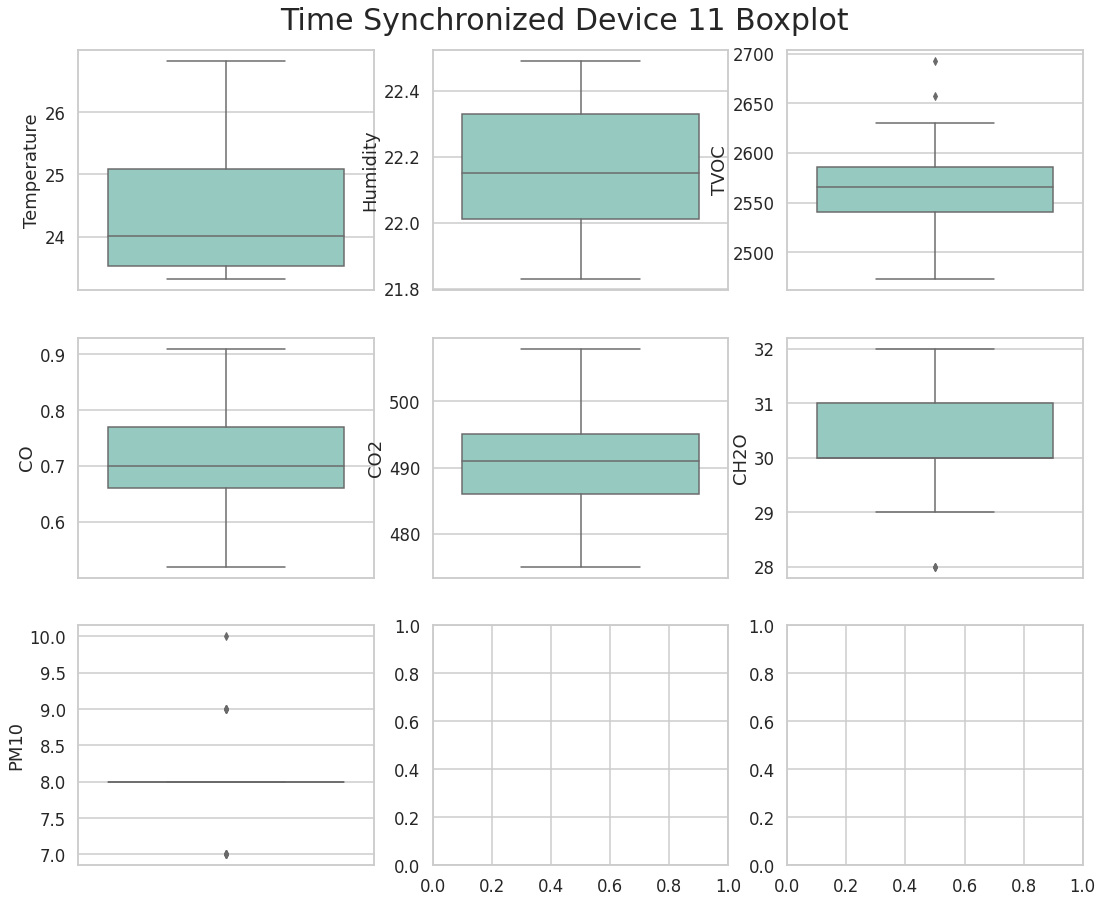

In [ ]:
boxplotEDA(d11_4,d11_4.columns[1:],3,3, 'Time Synchronized Device 11 Boxplot')

### Data Merge

In [ ]:
df_list = [d11_1,d11_2,d11_3,d11_4,d11_5]
df11 = pd.concat(df_list)
df11.rename(columns={'TsYMD':'Time'},inplace=True)
df11.drop_duplicates(subset=['Time'],inplace=True)
df11.reset_index(inplace=True,drop=True)
df11

Time  Temperature  Humidity    TVOC    CO    CO2  CH2O  \
0      2022-05-01 00:02        23.27     21.45  1377.0  0.99  545.0  25.0   
1      2022-05-01 00:04        20.51     21.46  1377.0  0.82  544.0  25.0   
2      2022-05-01 00:06        21.87     21.46  1383.0  0.50  546.0  25.0   
3      2022-05-01 00:08        21.87     21.48  1374.0  0.52  547.0  25.0   
4      2022-05-01 00:10        21.86     21.48  1380.0  0.37  548.0  25.0   
...                 ...          ...       ...     ...   ...    ...   ...   
13232  2022-05-19 11:12        28.23     21.03  3772.0  0.72  723.0  34.0   
13233  2022-05-19 11:14        28.23     21.03  3772.0  0.72  723.0  34.0   
13234  2022-05-19 11:16        28.32     21.02  3848.0  0.43  736.0  35.0   
13235  2022-05-19 11:18        28.37     20.99  3860.0  0.55  741.0  35.0   
13236  2022-05-19 11:20        27.05     20.98  3923.0  0.50  743.0  35.0   

       PM10  
0      18.0  
1      19.0  
2      18.0  
3      18.0  
4      18.0  
...     ...  
13232   5.0  
13233   5.0  
13234   5.0  
13235   5.0  
13236   5.0  

[13237 rows x 8 columns]

### Difference

In [ ]:
def adf_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] < pvalue:
       print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.")
    else:
       print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.")

In [ ]:
def adf_test1(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       print(timeseries.name,f"정상성이 보장됩니다.")
    else:
       print(timeseries.name,f"정상성을 보장하지 못합니다.")

In [ ]:
adf_test(df11['PM10'])

Results of Dickey-Fuller Test:
Test Statistic                    -5.360388
p-value                            0.000043
Lags Used                         34.000000
Number of Observations Used    13210.000000
Critical Value (1%)               -3.959455
Critical Value (5%)               -3.410822
Critical Value (10%)              -3.127246
dtype: float64
정상시계열이 아니라는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.


https://signature95.tistory.com/22 참고

In [ ]:
for i in range(7):
  adf_test1(df11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


device11로 하였을 경우, CO,NO2,H2S,NH3를 제외한 모든 부분에서 정상성을 만족한다.

In [ ]:
diff11=df11.copy()

In [ ]:
# 전체 1차 차분
for i in range(7):
    diff11.iloc[:,1+i]=diff11.iloc[:,1+i].replace(diff11.iloc[:,1+i].diff().dropna())

In [ ]:
for i in range(7):
  adf_test1(diff11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


In [ ]:
diff11

Time  Temperature  Humidity   TVOC    CO  CO2  CH2O  PM10
0      2022-05-01 00:02        23.27     21.45   12.0  0.99  0.0   0.0  -1.0
1      2022-05-01 00:04        20.51     21.46   12.0  0.82  0.0   0.0   0.0
2      2022-05-01 00:06        21.87     21.46    3.0  0.50  2.0   0.0  -1.0
3      2022-05-01 00:08        21.87     21.48   15.0  0.52 -2.0   0.0  -1.0
4      2022-05-01 00:10        21.86     21.48   -2.0  0.37  1.0   0.0  -1.0
...                 ...          ...       ...    ...   ...  ...   ...   ...
13232  2022-05-19 11:12        28.23     21.03    3.0  0.72 -1.0   0.0   1.0
13233  2022-05-19 11:14        28.23     21.03    3.0  0.72 -1.0   0.0   1.0
13234  2022-05-19 11:16        28.32     21.02    1.0  0.43 -1.0   0.0   1.0
13235  2022-05-19 11:18        28.37     20.99    1.0  0.55 -2.0   0.0   1.0
13236  2022-05-19 11:20        27.05     20.98 -201.0  0.50  0.0   0.0   1.0

[13237 rows x 8 columns]

In [ ]:
def diff1(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       timeseries=timeseries
    else:
       timeseries=timeseries.replace(timeseries.diff(1).dropna())
       
def diff2(timeseries, pvalue = .05, regression_option = 'ct'):
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    if dfoutput[1] < pvalue:
       timeseries=timeseries
    else:
       timeseries=timeseries.replace(timeseries.diff().diff().dropna())

In [ ]:
for i in range(7):
    diff1(diff11.iloc[:,1+i])
    diff2(diff11.iloc[:,1+i])

In [ ]:
for i in range(7):
    adf_test1(diff11.iloc[:,1+i])

Temperature 정상성이 보장됩니다.
Humidity 정상성이 보장됩니다.
TVOC 정상성이 보장됩니다.
CO 정상성이 보장됩니다.
CO2 정상성이 보장됩니다.
CH2O 정상성이 보장됩니다.
PM10 정상성이 보장됩니다.


### Outlier Process

In [ ]:
# Outlier Processing for 7 Features
for i in range(7):
    outliers_iqr(df11.iloc[:,1+i])

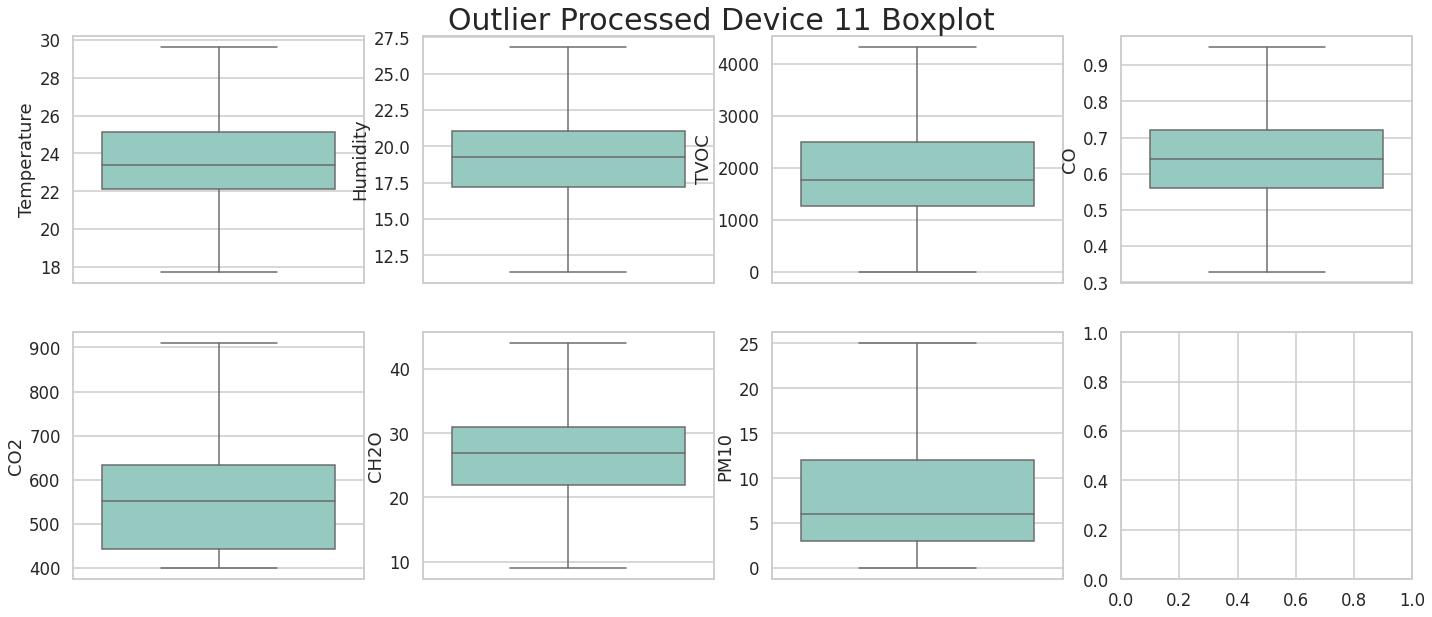

In [ ]:
# Outlier Processed Device 11 Boxplot
boxplotEDA(df11,df11.columns[1:],2,4,'Outlier Processed Device 11 Boxplot')

## 3. Modeling

### Modeling Preparation

In [ ]:
# DataFrame Time Indexing for Time Series Data
df11.set_index('Time',inplace=True)
diff11.set_index('Time',inplace=True)
print('df11 :',df11.shape)
print('diff11 :',diff11.shape)
df11.head()

df11 : (13237, 7)
diff11 : (13237, 7)


Temperature  Humidity    TVOC    CO    CO2  CH2O  PM10
Time                                                                    
2022-05-01 00:02        23.27     21.45  1377.0  0.82  545.0  25.0  18.0
2022-05-01 00:04        20.51     21.46  1377.0  0.82  544.0  25.0  19.0
2022-05-01 00:06        21.87     21.46  1383.0  0.50  546.0  25.0  18.0
2022-05-01 00:08        21.87     21.48  1374.0  0.52  547.0  25.0  18.0
2022-05-01 00:10        21.86     21.48  1380.0  0.37  548.0  25.0  18.0

In [ ]:
# Cleansed Data Save
df11.to_csv('data/df11.csv')

In [17]:
# Cleansed Data Load
df11 = pd.read_csv('data/df11.csv',index_col='Time')
print(df11.shape)
df11.head()

(13237, 7)


Temperature  Humidity    TVOC    CO    CO2  CH2O  PM10
Time                                                                    
2022-05-01 00:02        23.27     21.45  1377.0  0.82  545.0  25.0  18.0
2022-05-01 00:04        20.51     21.46  1377.0  0.82  544.0  25.0  19.0
2022-05-01 00:06        21.87     21.46  1383.0  0.50  546.0  25.0  18.0
2022-05-01 00:08        21.87     21.48  1374.0  0.52  547.0  25.0  18.0
2022-05-01 00:10        21.86     21.48  1380.0  0.37  548.0  25.0  18.0

In [18]:
# train_test_split | 0.8 : 0.2
sep = int(df11.shape[0] * 0.8)
X_train = df11.iloc[:sep,:]
X_test = df11.iloc[sep:,:]
print('X_train.shape:',X_train.shape)
print('X_test.shape:',X_test.shape)

X_train.shape: (10589, 7)
X_test.shape: (2648, 7)


In [19]:
# Normalization
norm = MinMaxScaler()
X_train_scaled = norm.fit_transform(X_train)
X_test_scaled = norm.transform(X_test)
print('X_train_scaled.shape :',X_train_scaled.shape)
print('X_test_scaled.shape :',X_test_scaled.shape)

X_train_scaled.shape : (10589, 7)
X_test_scaled.shape : (2648, 7)


In [20]:
# Data Formating
train = np.reshape(X_train_scaled, (-1, 1,7))
test = np.reshape(X_test_scaled[:-1], (-1, 1,7))
print('train.shape :',train.shape)
print('test.shape :',test.shape)

train.shape : (10589, 1, 7)
test.shape : (2647, 1, 7)


### LSTM-AE 

<b>Encoder

In [ ]:
# Encoder

encoder_input = keras.layers.Input(shape=(train.shape[1],train.shape[2]))

L1 = LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.0))(encoder_input)
L2 = LSTM(64, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.00))(L1)
L3 = LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.00))(L2)
L4 = LSTM(4, activation='relu', return_sequences=False)(L3)
L5 = keras.layers.RepeatVector(L3.shape[1])(L4)

encoder_output = L5

In [ ]:
encoder = keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 128)            69632     
                                                                 
 lstm_17 (LSTM)              (None, 1, 64)             49408     
                                                                 
 lstm_18 (LSTM)              (None, 1, 32)             12416     
                                                                 
 lstm_19 (LSTM)              (None, 4)                 592       
                                                                 
 repeat_vector_2 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                           

<b>Decoder

In [ ]:
# Decoder
decoder_input = keras.layers.Input(shape=(1,4))

L6 = LSTM(4, activation='relu', return_sequences=True)(decoder_input)
L7 = LSTM(32, activation='relu', return_sequences=True)(L6)
L8 = LSTM(64, activation='relu', return_sequences=True)(L7)
L9 = LSTM(128, activation='relu', return_sequences=True)(L8)
output = keras.layers.TimeDistributed(Dense(train.shape[2]))(L9)

decoder_output = output

In [ ]:
decoder = keras.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 4)]            0         
                                                                 
 lstm_20 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_21 (LSTM)              (None, 1, 32)             4736      
                                                                 
 lstm_22 (LSTM)              (None, 1, 64)             24832     
                                                                 
 lstm_23 (LSTM)              (None, 1, 128)            98816     
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 7)             903       
 tributed)                                                       
                                                           

<b>Connecting Encoder & Decoder

In [ ]:
# LSTM-AE = Encoder + Decoder

encoder_in = keras.layers.Input(shape=(1,7))
x = encoder(encoder_in)
decoder_out = decoder(x)

lstm_ae_model = keras.Model(encoder_in,decoder_out)
lstm_ae_model.compile(optimizer='adam', loss='mse')
lstm_ae_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 model_2 (Functional)        (None, 1, 4)              132048    
                                                                 
 model_4 (Functional)        (None, 1, 7)              129431    
                                                                 
Total params: 261,479
Trainable params: 261,479
Non-trainable params: 0
_________________________________________________________________


<b> LSTM-AE Model Training

In [ ]:
# Checkpoint Callback Function Definition
checkpoint_dir = 'lstm-ae-checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'

# 5번 에포크씩 val_loss 변화 확인- 변화 없을 시 학습 중단
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
cp = ModelCheckpoint(filepath=checkpoint_path, verbose=1,
                     save_weights_only=True,
                     save_best_only=True)

In [ ]:
# TQDM Tracking LSTN-AE Model Training
nb_epochs = 30
batch_size = 10
tqdm_callback = tfa.callbacks.TQDMProgressBar()
history = lstm_ae_model.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    callbacks=[early_stopping, cp, tqdm_callback], validation_split=0.05).history

Epoch 1/30


Epoch 1/30


998/998 [==============================] - ETA: 0s - loss: 0.0393
Epoch 1: val_loss improved from inf to 0.02350, saving model to lstm-ae-checkpoint\cp-0001-0.02.ckpt

998/998 [==============================] - 52s 47ms/step - loss: 0.0393 - val_loss: 0.0235
Epoch 2/30


Epoch 2/30
998/998 [==============================] - ETA: 0s - loss: 0.0224
Epoch 2: val_loss improved from 0.02350 to 0.01464, saving model to lstm-ae-checkpoint\cp-0002-0.01.ckpt

998/998 [==============================] - 45s 45ms/step - loss: 0.0224 - val_loss: 0.0146
Epoch 3/30


Epoch 3/30
998/998 [==============================] - ETA: 0s - loss: 0.0163
Epoch 3: val_loss improved from 0.01464 to 0.00684, saving model to lstm-ae-checkpoint\cp-0003-0.01.ckpt

998/998 [==============================] - 45s 45ms/step - loss: 0.0163 - val_loss: 0.0068
Epoch 4/30


Epoch 4/30
998/998 [==============================] - ETA: 0s - loss: 0.0126
Epoch 4: val_loss improved from 0.00684 to 0.00680, saving model to lstm-ae-checkpoint\cp-0004-0.01.ckpt

998/998 [==============================] - 48s 48ms/step - loss: 0.0126 - val_loss: 0.0068
Epoch 5/30


Epoch 5/30
997/998 [============================>.] - ETA: 0s - loss: 0.0119
Epoch 5: val_loss did not improve from 0.00680

998/998 [==============================] - 47s 47ms/step - loss: 0.0119 - val_loss: 0.0075
Epoch 6/30


Epoch 6/30
998/998 [==============================] - ETA: 0s - loss: 0.0115
Epoch 6: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0115 - val_loss: 0.0072
Epoch 7/30


Epoch 7/30
997/998 [============================>.] - ETA: 0s - loss: 0.0111
Epoch 7: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0111 - val_loss: 0.0075
Epoch 8/30


Epoch 8/30
998/998 [==============================] - ETA: 0s - loss: 0.0108
Epoch 8: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0108 - val_loss: 0.0085
Epoch 9/30


Epoch 9/30
998/998 [==============================] - ETA: 0s - loss: 0.0105
Epoch 9: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0105 - val_loss: 0.0073
Epoch 10/30


Epoch 10/30
998/998 [==============================] - ETA: 0s - loss: 0.0102
Epoch 10: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0102 - val_loss: 0.0082
Epoch 11/30


Epoch 11/30
998/998 [==============================] - ETA: 0s - loss: 0.0101
Epoch 11: val_loss did not improve from 0.00680

998/998 [==============================] - 46s 46ms/step - loss: 0.0101 - val_loss: 0.0076
Epoch 12/30


Epoch 12/30
998/998 [==============================] - ETA: 0s - loss: 0.0099
Epoch 12: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0099 - val_loss: 0.0074
Epoch 13/30


Epoch 13/30
997/998 [============================>.] - ETA: 0s - loss: 0.0099
Epoch 13: val_loss did not improve from 0.00680

998/998 [==============================] - 43s 43ms/step - loss: 0.0099 - val_loss: 0.0076
Epoch 14/30


Epoch 14/30
998/998 [==============================] - ETA: 0s - loss: 0.0097
Epoch 14: val_loss did not improve from 0.00680

998/998 [==============================] - 45s 45ms/step - loss: 0.0097 - val_loss: 0.0076



<b> LSTM-AE Model Save & Load

In [ ]:
# LSTM-AE 모델 저장
lstm_ae_model.save('lstm_model_save/lstm_ae_0621_0.026/')

# encoder 모델 저장
encoder.save('lstm_model_save/encoder_0621_0.026/')

# decoder 모델 저장
decoder.save('lstm_model_save/decoder_0621_0.026/')

In [21]:
# Model Load
lstm_ae_model = keras.models.load_model('lstm_model_save/lstm_ae_0621_0.026/')
encoder = keras.models.load_model('lstm_model_save/encoder_0621_0.026/')
decoder = keras.models.load_model('lstm_model_save/decoder_0621_0.026/')

<b>Model Performance Evaluation

Text(0.5, 1.0, 'Loss Curves')

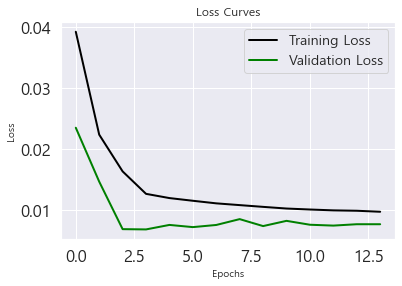

In [ ]:
# Loss curve of the training_set
plt.figure(figsize=[6,4])
plt.plot(history['loss'], 'black', linewidth=2.0)
plt.plot(history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

In [22]:
# Original Train DataSet
og_train = pd.DataFrame(X_train_scaled, columns = X_train.columns)
og_train.index = X_train.index
og_train.head()

Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-01 00:02     0.428571  0.651133  0.317867  0.790323  0.285996   
2022-05-01 00:04     0.180593  0.651780  0.317867  0.790323  0.284024   
2022-05-01 00:06     0.302785  0.651780  0.319252  0.274194  0.287968   
2022-05-01 00:08     0.302785  0.653074  0.317175  0.306452  0.289941   
2022-05-01 00:10     0.301887  0.653074  0.318560  0.064516  0.291913   

                      CH2O  PM10  
Time                              
2022-05-01 00:02  0.457143  0.72  
2022-05-01 00:04  0.457143  0.76  
2022-05-01 00:06  0.457143  0.72  
2022-05-01 00:08  0.457143  0.72  
2022-05-01 00:10  0.457143  0.72

In [23]:
# Prediction of Train DataSet
X_pred_train = lstm_ae_model.predict(train)

train_pred = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
train_pred = pd.DataFrame(train_pred, columns = X_train.columns)
train_pred.index = X_train.index
print('train_pred.shape :',train_pred.shape)
train_pred.head()

train_pred.shape : (10589, 7)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-01 00:02     0.291421  0.650018  0.323793  0.544382  0.292361   
2022-05-01 00:04     0.289492  0.655489  0.338804  0.581174  0.302894   
2022-05-01 00:06     0.299265  0.661781  0.319474  0.520895  0.287876   
2022-05-01 00:08     0.298261  0.662505  0.320981  0.525096  0.288165   
2022-05-01 00:10     0.314097  0.656748  0.312226  0.500143  0.304238   

                      CH2O      PM10  
Time                                  
2022-05-01 00:02  0.385658  0.730383  
2022-05-01 00:04  0.419345  0.718091  
2022-05-01 00:06  0.367983  0.754283  
2022-05-01 00:08  0.372094  0.752182  
2022-05-01 00:10  0.333091  0.772970

In [24]:
# Train data Reconstruction Error
train_score = RE_SCORE(X_train_scaled, train_pred)
train_score = train_score.set_index(train_score.index)
train_score.head()

RE_SCORE
Time                      
2022-05-01 00:02  0.012085
2022-05-01 00:04  0.008514
2022-05-01 00:06  0.010014
2022-05-01 00:08  0.008029
2022-05-01 00:10  0.029760

In [25]:
# Train Data Reconstruction Error Threshold
upper, lower= np.quantile(train_score['RE_SCORE'].values,0.75), np.quantile(train_score['RE_SCORE'].values,0.25)
iqr = upper-lower
train_boundary = upper + iqr*1.5
print('Train Data IQR Based boundary :',np.round(train_boundary,4))

Train Data IQR Based boundary : 0.0262


In [26]:
train_score['Threshold'] = train_boundary
train_score.head()

RE_SCORE  Threshold
Time                                 
2022-05-01 00:02  0.012085   0.026219
2022-05-01 00:04  0.008514   0.026219
2022-05-01 00:06  0.010014   0.026219
2022-05-01 00:08  0.008029   0.026219
2022-05-01 00:10  0.029760   0.026219

In [27]:
# Reconstruction Error of Train Set
fig = px.scatter(train_score, x=train_score.index, y='RE_SCORE', title='Reconstruction Error of Train Set')
fig.add_trace(go.Scatter(x=train_score.index, y=train_score['Threshold'], name='Threshold',
                         line=dict(width=5,dash='dash',color=('rgb(237,37,75)'))))

In [28]:
# Reconstruction Error Distribution of Train Set
fig = px.histogram(train_score, x="RE_SCORE", title ='Reconstruction Error Distribution of Train Set', marginal='box')
fig.add_vline(x=train_boundary, line_width=3, line_dash="dash", line_color="red",annotation_text="Threshold "+str(np.round(train_boundary,4)), annotation_position="bottom right")
fig.show()

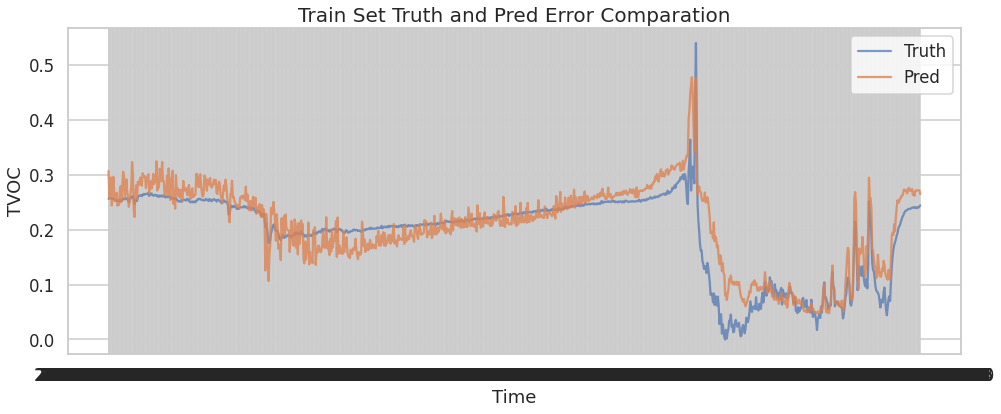

In [29]:
# Train Set Truth and Pred Error Comparation
plt.figure(figsize=(16,6))
sns.lineplot(og_train.index[300:1300], og_train['TVOC'][300:1300], alpha=0.7, label='Truth')
sns.lineplot(train_pred.index[300:1300], train_pred['TVOC'][300:1300], alpha=0.8, label='Pred')
plt.title('Train Set Truth and Pred Error Comparation',size=20)
plt.legend(loc='upper right')
plt.show()

In [30]:
# Test Set evaluation
lstm_ae_model.evaluate(test,test)

83/83 [==============================] - 1s 3ms/step - loss: 0.0169


0.016881871968507767

In [31]:
# Original Test DataSet
og_test = pd.DataFrame(X_test_scaled, columns = X_test.columns)
og_test.index = X_test.index
og_test.head()

Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-15 17:00     0.726864  0.248544  0.378347  0.822581  0.092702   
2022-05-15 17:02     0.601078  0.248544  0.375577  0.387097  0.092702   
2022-05-15 17:04     0.600180  0.247896  0.379963  0.451613  0.094675   
2022-05-15 17:06     0.599281  0.248544  0.375577  0.483871  0.098619   
2022-05-15 17:08     0.721473  0.247896  0.373500  0.483871  0.092702   

                      CH2O  PM10  
Time                              
2022-05-15 17:00  0.400000  0.04  
2022-05-15 17:02  0.400000  0.04  
2022-05-15 17:04  0.428571  0.04  
2022-05-15 17:06  0.457143  0.04  
2022-05-15 17:08  0.457143  0.04

In [32]:
# Prediction of Test Set
X_pred_test = lstm_ae_model.predict(test)

test_pred = X_pred_test.reshape(X_pred_test.shape[0], X_pred_test.shape[2])
test_pred = pd.DataFrame(test_pred, columns = X_test.columns)
test_pred.index = X_test.iloc[:-1,:].index
print('test_pred.shape :',test_pred.shape)
test_pred.head()

test_pred.shape : (2647, 7)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-15 17:00     0.744062  0.264756  0.293351  0.511239  0.102353   
2022-05-15 17:02     0.596610  0.338123  0.296578  0.495127  0.049998   
2022-05-15 17:04     0.596063  0.343226  0.305584  0.493967  0.055580   
2022-05-15 17:06     0.597372  0.347336  0.314608  0.492920  0.061891   
2022-05-15 17:08     0.702021  0.300053  0.324063  0.500571  0.107921   

                      CH2O      PM10  
Time                                  
2022-05-15 17:00  0.337036  0.130773  
2022-05-15 17:02  0.412484  0.116464  
2022-05-15 17:04  0.421993  0.114850  
2022-05-15 17:06  0.430693  0.113363  
2022-05-15 17:08  0.389859  0.119683

In [33]:
# Test Set reconstruction error
test_score = RE_SCORE(X_test_scaled[:-1], test_pred)
test_score = test_score.set_index(test_score.index)
test_score.head()

RE_SCORE
Time                      
2022-05-15 17:00  0.016716
2022-05-15 17:02  0.004826
2022-05-15 17:04  0.003372
2022-05-15 17:06  0.002999
2022-05-15 17:08  0.002419

In [34]:
# Train Data Reconstruction Error Threshold
upper, lower= np.quantile(test_score['RE_SCORE'].values,0.75), np.quantile(test_score['RE_SCORE'].values,0.25)
iqr = upper-lower
test_boundary = upper + iqr*1.5
print('Test Data IQR Based boundary :',np.round(test_boundary,4))

Test Data IQR Based boundary : 0.0441


In [35]:
test_score['Threshold'] = test_boundary
test_score.head()

RE_SCORE  Threshold
Time                                 
2022-05-15 17:00  0.016716   0.044108
2022-05-15 17:02  0.004826   0.044108
2022-05-15 17:04  0.003372   0.044108
2022-05-15 17:06  0.002999   0.044108
2022-05-15 17:08  0.002419   0.044108

In [36]:
# Reconstruction Error of Test Set
fig = px.scatter(test_score, x=test_score.index, y='RE_SCORE', title='Reconstruction Error of Test Set')
fig.add_trace(go.Scatter(x=test_score.index, y=test_score['Threshold'], name='Threshold',
                         line=dict(width=5,dash='dash',color=('rgb(237,37,75)'))))

In [37]:
# Reconstruction Error Distribution of Test Set
fig = px.histogram(test_score, x="RE_SCORE", title ='Reconstruction Error Distribution of Test Set', marginal='box')
fig.add_vline(x=test_boundary, line_width=3, line_dash="dash", line_color="red",annotation_text="Threshold "+str(np.round(test_boundary,4)), annotation_position="bottom right")
fig.show()

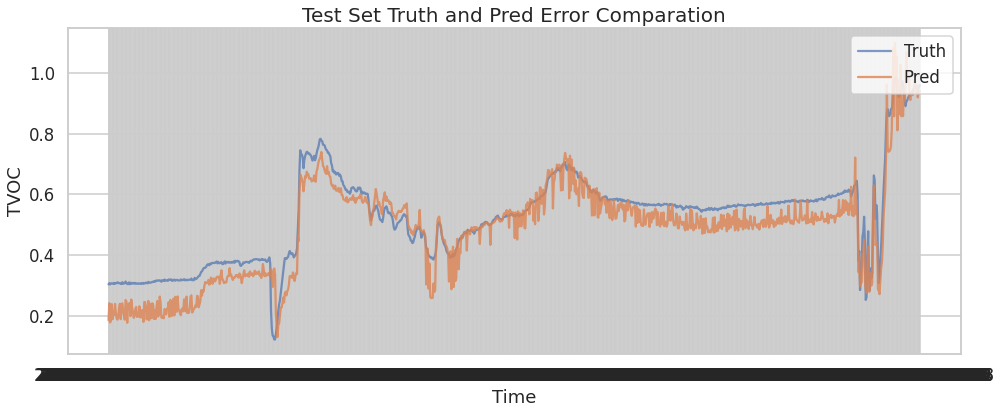

In [38]:
# Test Set Truth and Pred Error Comparation
plt.figure(figsize=(16,6))
sns.lineplot(og_test.index[300:1300], og_test['TVOC'][300:1300], alpha=0.7, label='Truth')
sns.lineplot(test_pred.index[300:1300], test_pred['TVOC'][300:1300], alpha=0.8, label='Pred')
plt.title('Test Set Truth and Pred Error Comparation',size=20)
plt.legend(loc='upper right')
plt.show()

In [39]:
# Total_score DataFrame Definition
total_score = train_score.copy()
total_score = pd.concat([total_score, test_score])
total_score.drop('Threshold',axis=1,inplace=True)

In [40]:
# Train Data Reconstruction Error Threshold
upper, lower= np.quantile(total_score['RE_SCORE'].values,0.75), np.quantile(total_score['RE_SCORE'].values,0.25)
iqr = upper-lower
total_boundary = upper + iqr*1.5
print('Total Data IQR Based boundary :',np.round(total_boundary,4))

Total Data IQR Based boundary : 0.031


In [41]:
# Anomaly Detection
total_score['Threshold'] = total_boundary
total_score['Anomaly'] = total_score['RE_SCORE'] > total_score['Threshold']
print('total_score.shape :',total_score.shape)
total_score.head()

total_score.shape : (13236, 3)


RE_SCORE  Threshold  Anomaly
Time                                          
2022-05-01 00:02  0.012085   0.030983    False
2022-05-01 00:04  0.008514   0.030983    False
2022-05-01 00:06  0.010014   0.030983    False
2022-05-01 00:08  0.008029   0.030983    False
2022-05-01 00:10  0.029760   0.030983    False

In [42]:
total_score['Anomaly'].value_counts()

False    12628
True       608
Name: Anomaly, dtype: int64

In [43]:
fig = px.scatter(total_score, x=total_score.index, y='RE_SCORE', title='Total Reconstruction Error & Threshold')
fig.add_trace(go.Scatter(x=total_score.index, y=total_score['Threshold'], name='Threshold',
                         line=dict(width=5,dash='dash',color=('rgb(237,37,75)'))))
fig.show()

In [44]:
fig = px.histogram(total_score, x="RE_SCORE", title ='Reconstruction Error Distribution of Total DataSet', marginal='box')
fig.add_vline(x=total_boundary, line_width=3, line_dash="dash", line_color="red",annotation_text="Threshold "+str(np.round(total_boundary,4)), annotation_position="bottom right")
fig.show()

### Deep Compact Clustering

<b> Normal Data Extraction

In [45]:
train_set = pd.concat([pd.DataFrame(X_train_scaled,columns=X_train.columns,index=X_train.index),train_score],axis=1)
print('train_set.shape :',train_set.shape)
train_set.head(2)

train_set.shape : (10589, 9)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-01 00:02     0.428571  0.651133  0.317867  0.790323  0.285996   
2022-05-01 00:04     0.180593  0.651780  0.317867  0.790323  0.284024   

                      CH2O  PM10  RE_SCORE  Threshold  
Time                                                   
2022-05-01 00:02  0.457143  0.72  0.012085   0.026219  
2022-05-01 00:04  0.457143  0.76  0.008514   0.026219

In [46]:
Threshold = train_boundary
normal = train_set[train_set['RE_SCORE'] <= Threshold]
print('normal.shape :',normal.shape)
normal.head(2)

normal.shape : (10038, 9)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-05-01 00:02     0.428571  0.651133  0.317867  0.790323  0.285996   
2022-05-01 00:04     0.180593  0.651780  0.317867  0.790323  0.284024   

                      CH2O  PM10  RE_SCORE  Threshold  
Time                                                   
2022-05-01 00:02  0.457143  0.72  0.012085   0.026219  
2022-05-01 00:04  0.457143  0.76  0.008514   0.026219

In [47]:
normal_data = normal.drop(['RE_SCORE','Threshold'],axis=1).to_numpy().reshape(-1,1,7)
normal_data.shape

(10038, 1, 7)

<b> Embedded Feature Extraction

In [48]:
embedded = pd.DataFrame(encoder.predict(normal_data).reshape(-1,4))
embedded.head(1)

0         1         2    3
0  0.0  1.571607  2.434509  0.0

In [49]:
embedded = embedded.iloc[:,[1,2]].rename(columns={1:'comp1',2:'comp2'})
print('embedded.shape :',embedded.shape)
embedded.head()

embedded.shape : (10038, 2)


comp1     comp2
0  1.571607  2.434509
1  1.543619  2.602139
2  1.574490  2.396089
3  1.572682  2.407230
4  1.536229  2.633832

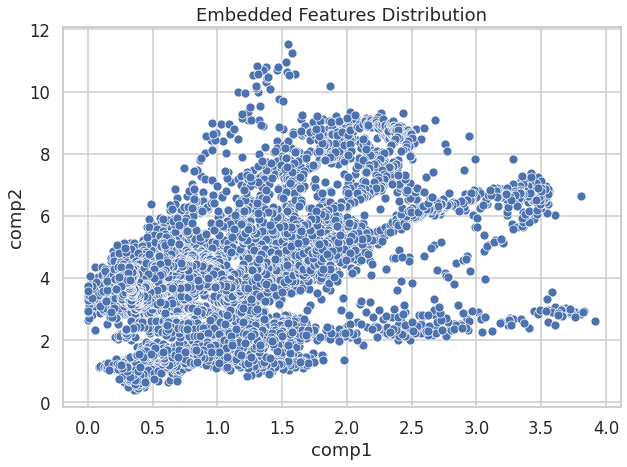

In [50]:
plt.figure(figsize=(10,7))
plt.title('Embedded Features Distribution')
sns.scatterplot(embedded.iloc[:,0], embedded.iloc[:,1], cmap=plt.get_cmap('Paired'))
plt.show()

<b> 밀도 기반 군집화 모델 : DBSCAN

In [51]:
dbscan = DBSCAN(eps = 0.8, min_samples=250, metric='euclidean')
dbscan_labels = dbscan.fit_predict(embedded)

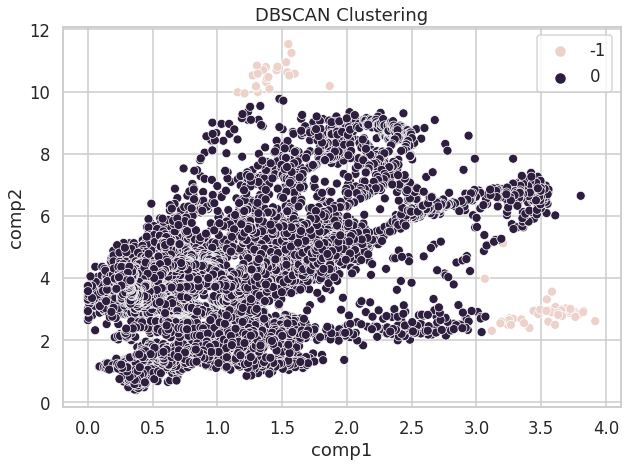

In [52]:
plt.figure(figsize=(10,7))
plt.title('DBSCAN Clustering')
sns.scatterplot(embedded.iloc[:,0], embedded.iloc[:,1], hue=dbscan_labels)
plt.show()

In [53]:
embedded['label'] = dbscan_labels
print('embedded.shape :',embedded.shape)
embedded.head()

embedded.shape : (10038, 3)


comp1     comp2  label
0  1.571607  2.434509      0
1  1.543619  2.602139      0
2  1.574490  2.396089      0
3  1.572682  2.407230      0
4  1.536229  2.633832      0

In [54]:
cluster = embedded[embedded['label'] == 0 ].drop('label',axis=1)
print('cluster.shape :',cluster.shape)
cluster.head()

cluster.shape : (9975, 2)


comp1     comp2
0  1.571607  2.434509
1  1.543619  2.602139
2  1.574490  2.396089
3  1.572682  2.407230
4  1.536229  2.633832

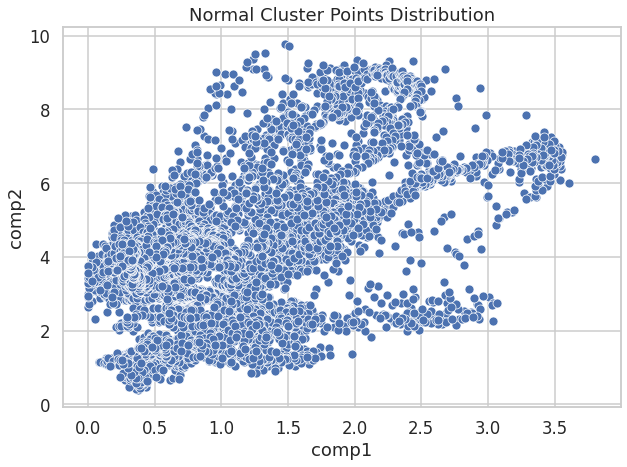

In [55]:
plt.figure(figsize=(10,7))
plt.title('Normal Cluster Points Distribution')
sns.scatterplot(cluster.iloc[:,0], cluster.iloc[:,1], cmap=plt.get_cmap('Paired'))
plt.show()

### OC-SVM

In [56]:
oc_svm = OneClassSVM(kernel='rbf',gamma='auto',nu=0.003)
oc_svm.fit(cluster[['comp1','comp2']])

OneClassSVM(gamma='auto', nu=0.003)

In [57]:
cluster['label'] = oc_svm.predict(cluster[['comp1','comp2']])
cluster['label'] = np.array([0,0,1])[cluster['label'].values]
cluster.head(1)

comp1     comp2  label
0  1.571607  2.434509      0

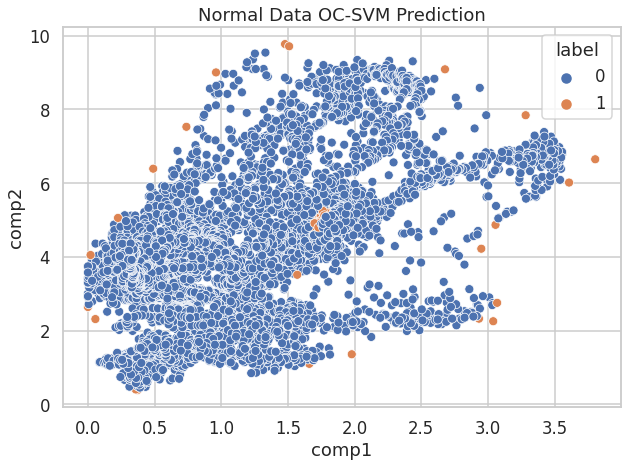

In [58]:
plt.figure(figsize=(10,7))
plt.title('Normal Data OC-SVM Prediction')
sns.scatterplot(cluster.iloc[:,0], cluster.iloc[:,1], cmap=plt.get_cmap('Paired'), hue=cluster.iloc[:,2])
plt.show()

In [59]:
test_feature = pd.DataFrame(encoder.predict(test).reshape(-1,4))
test_feature.head(1)

0        1         2    3
0  0.0  0.14251  3.850989  0.0

In [60]:
test_feature = test_feature.iloc[:,[1,2]].rename(columns={1:'comp1',2:'comp2'})
test_feature.index = test_score.index
print('test_feature.shape :',test_feature.shape)
test_feature.head()

test_feature.shape : (2647, 2)


comp1     comp2
Time                                
2022-05-15 17:00  0.142510  3.850989
2022-05-15 17:02  0.212137  3.622847
2022-05-15 17:04  0.228675  3.677374
2022-05-15 17:06  0.243456  3.710584
2022-05-15 17:08  0.214908  3.860944

In [61]:
test_feature['DCC_score'] = oc_svm.score_samples(test_feature[['comp1','comp2']])
test_feature['distance'] = oc_svm.decision_function(test_feature[['comp1','comp2']])
test_feature['DCC_label'] = oc_svm.predict(test_feature[['comp1','comp2']])
test_feature['DCC_label'] = np.array([0,0,1])[test_feature['DCC_label'].values]
test_feature.head()

comp1     comp2  DCC_score  distance  DCC_label
Time                                                                
2022-05-15 17:00  0.142510  3.850989   3.705200  0.116960          0
2022-05-15 17:02  0.212137  3.622847   3.753676  0.165436          0
2022-05-15 17:04  0.228675  3.677374   3.761379  0.173139          0
2022-05-15 17:06  0.243456  3.710584   3.768078  0.179838          0
2022-05-15 17:08  0.214908  3.860944   3.750240  0.162000          0

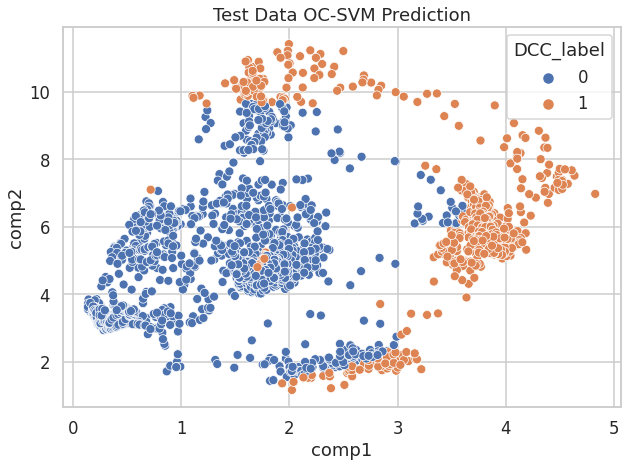

In [62]:
plt.figure(figsize=(10,7))
plt.title('Test Data OC-SVM Prediction')
sns.scatterplot(test_feature['comp1'], test_feature['comp2'], cmap=plt.get_cmap('Paired'), hue=test_feature['DCC_label'])
plt.show()

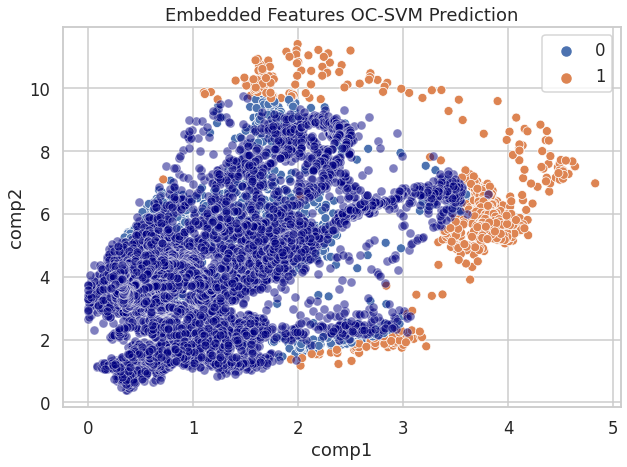

In [63]:
plt.figure(figsize=(10,7))
plt.title('Embedded Features OC-SVM Prediction')
sns.scatterplot(test_feature['comp1'], test_feature['comp2'], cmap=plt.get_cmap('Paired'), hue=test_feature['DCC_label'])
sns.scatterplot(cluster['comp1'], cluster['comp2'], cmap=plt.get_cmap('Paired'), color='navy', alpha=0.5)
plt.show()

### Decision Rule Definition

<b> 1. Reconstruction Error Based Model

In [64]:
RE_model = lstm_ae_model

In [65]:
test_score['RE_label'] = (test_score['RE_SCORE'] > train_boundary).astype('int')
re_score = test_feature[['comp1','comp2']]
re_score = pd.concat([re_score,test_score[['RE_SCORE','RE_label']]],axis=1)
print(re_score.shape)
re_score.head()

(2647, 4)


comp1     comp2  RE_SCORE  RE_label
Time                                                    
2022-05-15 17:00  0.142510  3.850989  0.016716         0
2022-05-15 17:02  0.212137  3.622847  0.004826         0
2022-05-15 17:04  0.228675  3.677374  0.003372         0
2022-05-15 17:06  0.243456  3.710584  0.002999         0
2022-05-15 17:08  0.214908  3.860944  0.002419         0

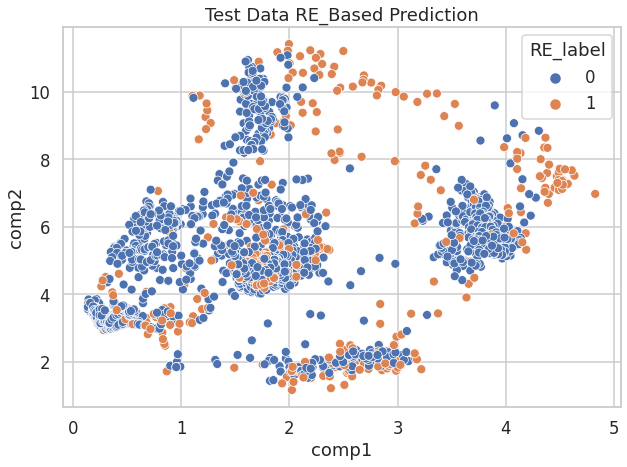

In [66]:
plt.figure(figsize=(10,7))
plt.title('Test Data RE_Based Prediction')
sns.scatterplot(re_score['comp1'], re_score['comp2'], cmap=plt.get_cmap('Paired'), hue=re_score['RE_label'])
plt.show()

<b> 2. DCC OC-SVM Based Model

In [67]:
DCC_model = oc_svm

In [68]:
dcc_score = test_feature
dcc_score.index = test_score.index
print(dcc_score.shape)
dcc_score.head()

(2647, 5)


comp1     comp2  DCC_score  distance  DCC_label
Time                                                                
2022-05-15 17:00  0.142510  3.850989   3.705200  0.116960          0
2022-05-15 17:02  0.212137  3.622847   3.753676  0.165436          0
2022-05-15 17:04  0.228675  3.677374   3.761379  0.173139          0
2022-05-15 17:06  0.243456  3.710584   3.768078  0.179838          0
2022-05-15 17:08  0.214908  3.860944   3.750240  0.162000          0

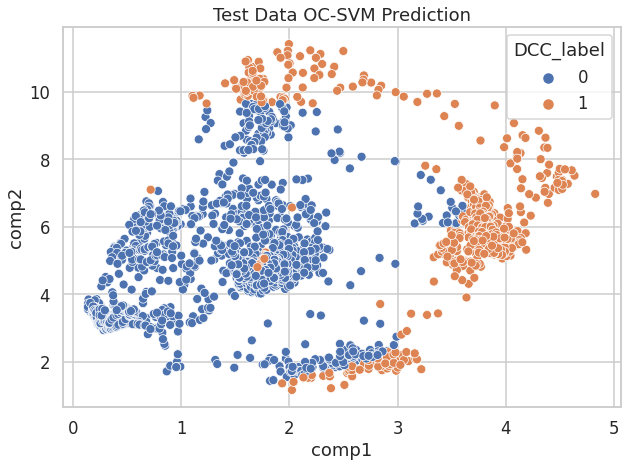

In [69]:
plt.figure(figsize=(10,7))
plt.title('Test Data OC-SVM Prediction')
sns.scatterplot(dcc_score['comp1'], dcc_score['comp2'], cmap=plt.get_cmap('Paired'), hue=dcc_score['DCC_label'])
plt.show()

<b> 3. DCC LSTM-AE Model

## 4. Simulation

### Simultation Data Preprocessing

In [70]:
print(df11.shape)
df11.head(2)

(13237, 7)


Temperature  Humidity    TVOC    CO    CO2  CH2O  PM10
Time                                                                    
2022-05-01 00:02        23.27     21.45  1377.0  0.82  545.0  25.0  18.0
2022-05-01 00:04        20.51     21.46  1377.0  0.82  544.0  25.0  19.0

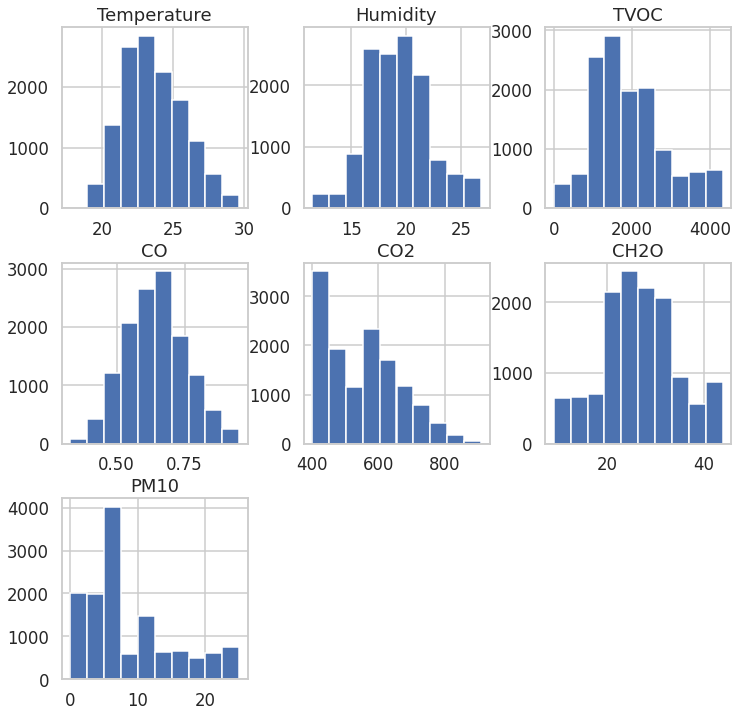

In [71]:
df11.hist(figsize=(12,12))
plt.show()

In [72]:
# Simul Data Preprocessing
simul_df = pd.read_csv('data/device16_0701.csv')
simul_df = simul_df[['TsYMD','Temperature','Humidity','TVOC','CO','CO2','CH2O','PM10']]
simul_df['TsYMD'] = pd.to_datetime(simul_df['TsYMD'])
simul_df = simul_df.sort_values('TsYMD')
simul_df['TsYMD'] = simul_df['TsYMD'].dt.to_period(freq='min')
simul_df.rename(columns={'TsYMD':'Time'},inplace=True)
time =simul_df['Time'].apply(lambda x: x.strftime('%Y%m%d%H%M'))
simul_df.index = simul_df['Time']
simul_df.drop('Time',axis=1,inplace=True)
print('simul_df.shape :',simul_df.shape)
simul_df.head()

simul_df.shape : (299, 7)


Temperature  Humidity   TVOC    CO    CO2  CH2O  PM10
Time                                                                   
2022-07-01 00:01        26.35     41.69  853.0  1.12  577.0  47.0   0.0
2022-07-01 00:03        23.60     41.73  847.0  1.11  572.0  47.0   0.0
2022-07-01 00:05        23.60     41.60  847.0  0.87  576.0  47.0   1.0
2022-07-01 00:07        23.60     41.29  903.0  0.98  583.0  48.0   1.0
2022-07-01 00:09        23.60     41.14  915.0  0.86  587.0  51.0   0.0

In [75]:
simul_df['2022-07-01 00:00':'2022-07-01 09:00']

Temperature  Humidity    TVOC    CO    CO2    CH2O  PM10
Time                                                                      
2022-07-01 00:01        26.35     41.69   853.0  1.12  577.0    47.0   0.0
2022-07-01 00:03        23.60     41.73   847.0  1.11  572.0    47.0   0.0
2022-07-01 00:05        23.60     41.60   847.0  0.87  576.0    47.0   1.0
2022-07-01 00:07        23.60     41.29   903.0  0.98  583.0    48.0   1.0
2022-07-01 00:09        23.60     41.14   915.0  0.86  587.0    51.0   0.0
...                       ...       ...     ...   ...    ...     ...   ...
2022-07-01 08:52        23.04     33.12  8619.0  0.84  579.0  1034.0   2.0
2022-07-01 08:54        23.09     32.93  2562.0  0.89  400.0   202.0   3.0
2022-07-01 08:56        23.10     32.26  1442.0  1.00  400.0    60.0   3.0
2022-07-01 08:58        23.11     31.73   938.0  1.03  400.0    18.0   3.0
2022-07-01 09:00        23.11     31.64   727.0  0.96  400.0    13.0   3.0

[270 rows x 7 columns]

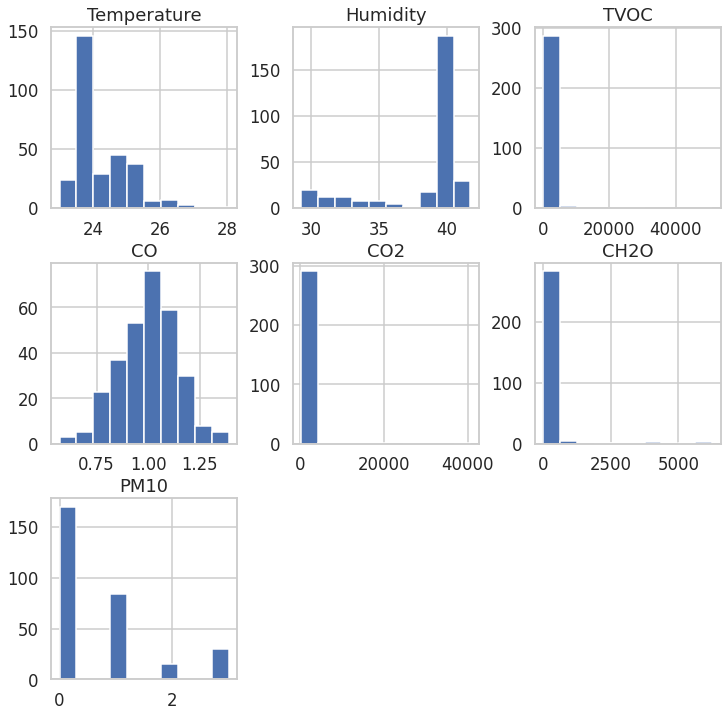

In [124]:
simul_df.hist(figsize=(12,12))
plt.show()

(0.0, 2000.0)

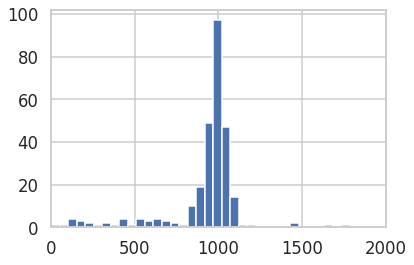

In [123]:
plt.hist(simul_df['TVOC'],bins=1000)
plt.xlim([0,2000])

In [113]:
simul_df['CH2O'].sort_values().value_counts()

70.0    51
76.0    16
67.0    14
72.0    14
77.0    12
        ..
22.0     1
20.0     1
90.0     1
15.0     1
13.0     1
Name: CH2O, Length: 76, dtype: int64

In [81]:
simul_len = simul_df.shape[0]

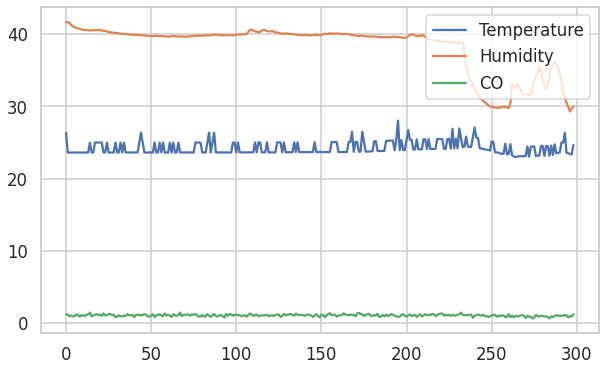

In [82]:
plt.figure(figsize=(10,6))
sns.lineplot(np.arange(simul_len),simul_df['Temperature'].values, label='Temperature')
sns.lineplot(np.arange(simul_len),simul_df['Humidity'].values, label='Humidity')
sns.lineplot(np.arange(simul_len),simul_df['CO'].values, label='CO')
plt.show()

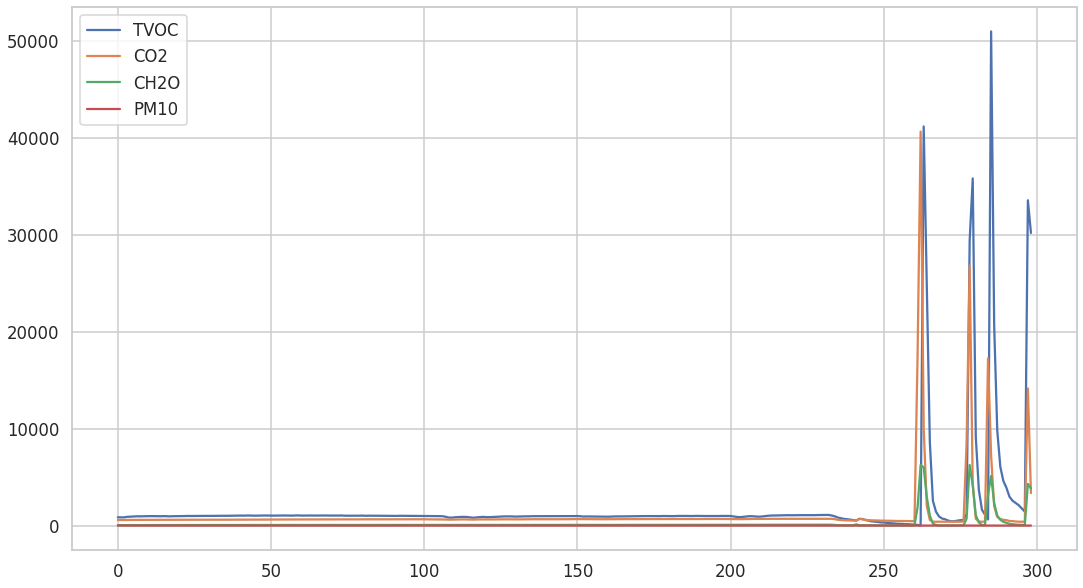

In [83]:
plt.figure(figsize=(18,10))
sns.lineplot(np.arange(simul_len),simul_df['TVOC'].values, label='TVOC')
sns.lineplot(np.arange(simul_len),simul_df['CO2'].values, label='CO2')
sns.lineplot(np.arange(simul_len),simul_df['CH2O'].values, label='CH2O')
sns.lineplot(np.arange(simul_len),simul_df['PM10'].values, label='PM10')
plt.show()

In [84]:
simul_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 299 entries, 2022-07-01 00:01 to 2022-07-01 09:58
Freq: T
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  299 non-null    float64
 1   Humidity     299 non-null    float64
 2   TVOC         299 non-null    float64
 3   CO           299 non-null    float64
 4   CO2          299 non-null    float64
 5   CH2O         299 non-null    float64
 6   PM10         299 non-null    float64
dtypes: float64(7)
memory usage: 26.8 KB


In [85]:
time

0      202207010001
1      202207010003
2      202207010005
3      202207010007
4      202207010009
           ...     
294    202207010950
295    202207010952
296    202207010954
297    202207010956
298    202207010958
Name: Time, Length: 299, dtype: object

In [86]:
check_list=[0]
for i in range(1,len(time)):
  now=datetime.strptime(time[i],'%Y%m%d%H%M')
  past=datetime.strptime(time[i-1],'%Y%m%d%H%M')
  diff=now-past
  diff=diff.seconds/60
  if diff >6:
    check_list.append(i)
check_list.append(len(time))

In [87]:
check_list

[0, 299]

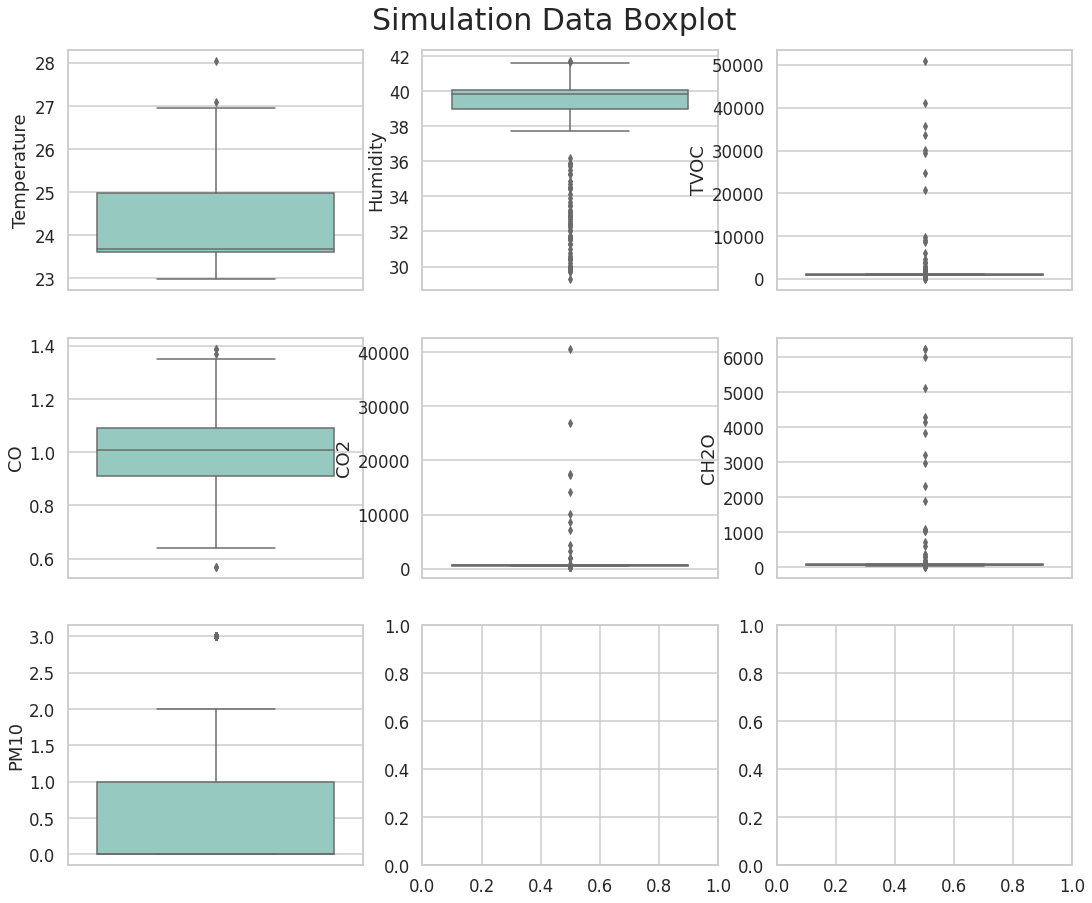

In [88]:
boxplotEDA(simul_df,simul_df.columns,3,3, 'Simulation Data Boxplot')

In [89]:
X_simul = norm.transform(simul_df)
print('X_simul.shape :',X_simul.shape)

X_simul.shape : (299, 7)


In [90]:
X_simul = np.reshape(X_simul, (-1, 1,7))
print('X_simul.shape :',X_simul.shape)

X_simul.shape : (299, 1, 7)


### Simulation Data Reconstruction Error

In [91]:
# Original Simulation DataSet
og_simul = pd.DataFrame(X_simul.reshape(-1,7), columns = simul_df.columns)
og_simul.index = simul_df.index
og_simul.head()

Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-07-01 00:01     0.705301  1.961165  0.196907  1.274194  0.349112   
2022-07-01 00:03     0.458221  1.963754  0.195522  1.258065  0.339250   
2022-07-01 00:05     0.458221  1.955340  0.195522  0.870968  0.347140   
2022-07-01 00:07     0.458221  1.935275  0.208449  1.048387  0.360947   
2022-07-01 00:09     0.458221  1.925566  0.211219  0.854839  0.368836   

                      CH2O  PM10  
Time                              
2022-07-01 00:01  1.085714  0.00  
2022-07-01 00:03  1.085714  0.00  
2022-07-01 00:05  1.085714  0.04  
2022-07-01 00:07  1.114286  0.04  
2022-07-01 00:09  1.200000  0.00

In [92]:
# Prediction of Simul DataSet
X_pred_simul = lstm_ae_model.predict(X_simul)

simul_pred = X_pred_simul.reshape(X_pred_simul.shape[0], X_pred_simul.shape[2])
simul_pred = pd.DataFrame(simul_pred, columns = simul_df.columns)
simul_pred.index = simul_df.index
print('simul_pred.shape :',simul_pred.shape)
simul_pred.head()

simul_pred.shape : (299, 7)


Temperature  Humidity      TVOC        CO       CO2  \
Time                                                                    
2022-07-01 00:01     0.416990  0.851169  0.708548  0.488132  0.433216   
2022-07-01 00:03     0.467028  0.749663  0.765578  0.504555  0.476010   
2022-07-01 00:05     0.459071  0.765238  0.756226  0.501685  0.469336   
2022-07-01 00:07     0.449586  0.784584  0.750247  0.490095  0.468669   
2022-07-01 00:09     0.446126  0.790296  0.752138  0.478806  0.475016   

                      CH2O      PM10  
Time                                  
2022-07-01 00:01  0.890713  0.331642  
2022-07-01 00:03  0.870489  0.235425  
2022-07-01 00:05  0.873095  0.251188  
2022-07-01 00:07  0.887537  0.287857  
2022-07-01 00:09  0.900933  0.315310

In [93]:
# Simul data Reconstruction Error
simul_score = RE_SCORE(og_simul, simul_pred)
simul_score = simul_score.set_index(simul_score.index)
simul_score.head()

RE_SCORE
Time                      
2022-07-01 00:01  0.335710
2022-07-01 00:03  0.355327
2022-07-01 00:05  0.281692
2022-07-01 00:07  0.293408
2022-07-01 00:09  0.274731

In [94]:
# Simul Data Reconstruction Error Threshold
upper, lower= np.quantile(simul_score['RE_SCORE'].values,0.75), np.quantile(simul_score['RE_SCORE'].values,0.25)
iqr = upper-lower
simul_boundary = upper + iqr*1.5
print('Simul Data IQR Based boundary :',np.round(simul_boundary,4))

Simul Data IQR Based boundary : 0.9207


In [95]:
simul_score['Threshold'] = simul_boundary
simul_score.head()

RE_SCORE  Threshold
Time                                 
2022-07-01 00:01  0.335710   0.920683
2022-07-01 00:03  0.355327   0.920683
2022-07-01 00:05  0.281692   0.920683
2022-07-01 00:07  0.293408   0.920683
2022-07-01 00:09  0.274731   0.920683

In [96]:
simul_score.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 299 entries, 2022-07-01 00:01 to 2022-07-01 09:58
Freq: T
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   RE_SCORE   299 non-null    float64
 1   Threshold  299 non-null    float64
dtypes: float64(2)
memory usage: 7.0 KB


In [97]:
# Reconstruction Error of Simul Data
fig = px.scatter(simul_score, x=simul_score.index.to_timestamp(), y='RE_SCORE', title='Reconstruction Error of Simul Set')
fig.add_trace(go.Scatter(x=simul_score.index.to_timestamp(), y=simul_score['Threshold'], name='Threshold',
                         line=dict(width=5,dash='dash',color=('rgb(237,37,75)'))))

In [104]:
# Reconstruction Error Distribution of Simul Data
fig = px.histogram(simul_score, x="RE_SCORE", title ='Reconstruction Error Distribution of Simul Data', marginal='box')
fig.add_vline(x=simul_boundary, line_width=3, line_dash="dash", line_color="red",annotation_text="Threshold "+str(np.round(simul_boundary,4)), annotation_position="bottom right")
fig.show()

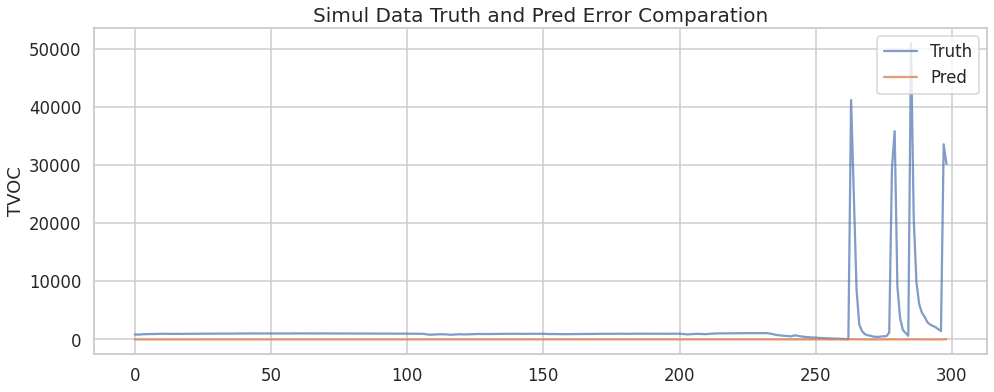

In [108]:
# Simul Data Truth and Pred Error Comparation
plt.figure(figsize=(16,6))
sns.lineplot(np.arange(simul_len), simul_df['TVOC'], alpha=0.7, label='Truth')
sns.lineplot(np.arange(simul_len), simul_pred['TVOC'], alpha=0.8, label='Pred')
plt.title('Simul Data Truth and Pred Error Comparation',size=20)
plt.legend(loc='upper right')
plt.show()

### Simulation Data Clustering

In [109]:
embedded_simul = pd.DataFrame(encoder.predict(X_simul).reshape(-1,4))
embedded_simul.head(1)

0         1         2    3
0  0.0  3.356761  6.410505  0.0

In [110]:
embedded_simul = embedded_simul.iloc[:,[1,2]].rename(columns={1:'comp1',2:'comp2'})
print('embedded_simul.shape :',embedded_simul.shape)
embedded_simul.head()

embedded_simul.shape : (299, 2)


comp1     comp2
0  3.356761  6.410505
1  3.278873  6.371663
2  3.443181  6.522350
3  3.470872  6.570895
4  3.610587  6.833811

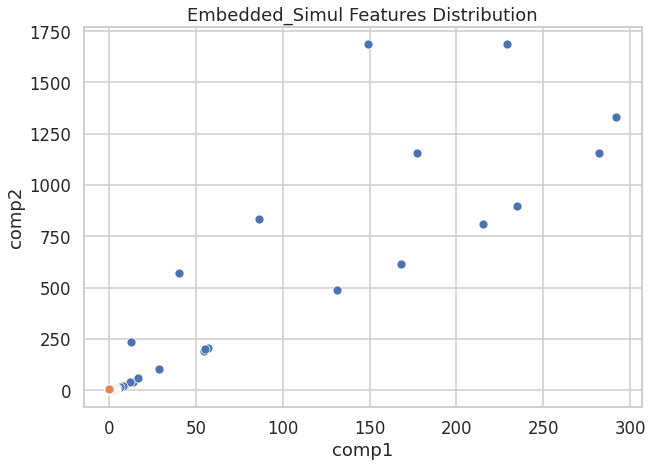

In [111]:
plt.figure(figsize=(10,7))
plt.title('Embedded_Simul Features Distribution')
sns.scatterplot(embedded_simul.iloc[:,0], embedded_simul.iloc[:,1], cmap=plt.get_cmap('Paired'))
sns.scatterplot(cluster.iloc[:,0], cluster.iloc[:,1], cmap=plt.get_cmap('Paired'))
plt.show()

In [102]:
cluster

comp1     comp2  label
0      1.571607  2.434509      0
1      1.543619  2.602139      0
2      1.574490  2.396089      0
3      1.572682  2.407230      0
4      1.536229  2.633832      0
...         ...       ...    ...
10033  0.301521  3.925565      0
10034  0.327730  3.919861      0
10035  0.239450  4.022066      0
10036  0.258433  3.755135      0
10037  0.219871  3.651920      0

[9975 rows x 3 columns]